In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
#file1 = '/Users/Павел/Documents/Курсовой проект/XLS/Countries.csv'
file1 = '/Users/Administrator/Documents/GitHub/Data-Analyst-Project/XLS/Countries.csv'
df = pd.read_csv(file1,
     dtype={'Year': 'int16', 
            'Total_weight_kg': 'float32', 
            'lines': 'float32', 
            'stations': 'float32', 
            'annual_ridership_mill': 'float32',
            'Population_eating_chocolate': 'float32',
            'Cost_kg_USD': 'float32',
            'Urban_population': 'float32',
            'Lifetime': 'float32',
            'GDP_USD': 'float32',
            'Inflation': 'float32',
            'kg_per_person': 'float32',
            'kg_per_GDP': 'float32'})

In [3]:
df

,Country,Year,Total_weight_kg,availability_of_metro,lines,stations,annual_ridership_mill,Population_eating_chocolate,Cost_kg_USD,Urban_population,Lifetime,GDP_USD,Inflation,kg_per_person,kg_per_GDP
0,Albania,1996,273411.0,No,NaN,NaN,NaN,1557925.0,6.214,39.473000,74.112999,985.820007,12.725478,0.1755,277.343689
1,Albania,1997,222897.0,No,NaN,NaN,NaN,1550237.0,6.214,40.035000,73.383003,688.820007,33.180275,0.1438,323.592499
2,Albania,1998,243309.0,No,NaN,NaN,NaN,1540864.0,6.214,40.601002,74.357002,795.880005,20.642859,0.1579,305.710693
3,Albania,1999,420293.0,No,NaN,NaN,NaN,1530526.0,6.214,41.168999,74.568001,1010.369995,0.389438,0.2746,415.979309
4,Albania,2000,303615.0,No,NaN,NaN,NaN,1519751.0,6.214,41.741001,74.825996,1101.520020,0.050018,0.1998,275.632812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,Zimbabwe,2012,629857.0,No,NaN,NaN,NaN,4559903.0,8.215,32.834000,55.386002,1238.599976,3.725327,0.1381,508.523285
3067,Zimbabwe,2013,556758.0,No,NaN,NaN,NaN,4624557.0,8.215,32.653999,56.841999,1362.300049,1.634950,0.1204,408.689697
3068,Zimbabwe,2014,576602.0,No,NaN,NaN,NaN,4688428.0,8.215,32.504002,58.105999,1372.209961,-0.197785,0.1230,420.199493
3069,Zimbabwe,2015,486762.0,No,NaN,NaN,NaN,4751674.0,8.215,32.384998,58.988998,1386.420044,-2.430969,0.1024,351.092712


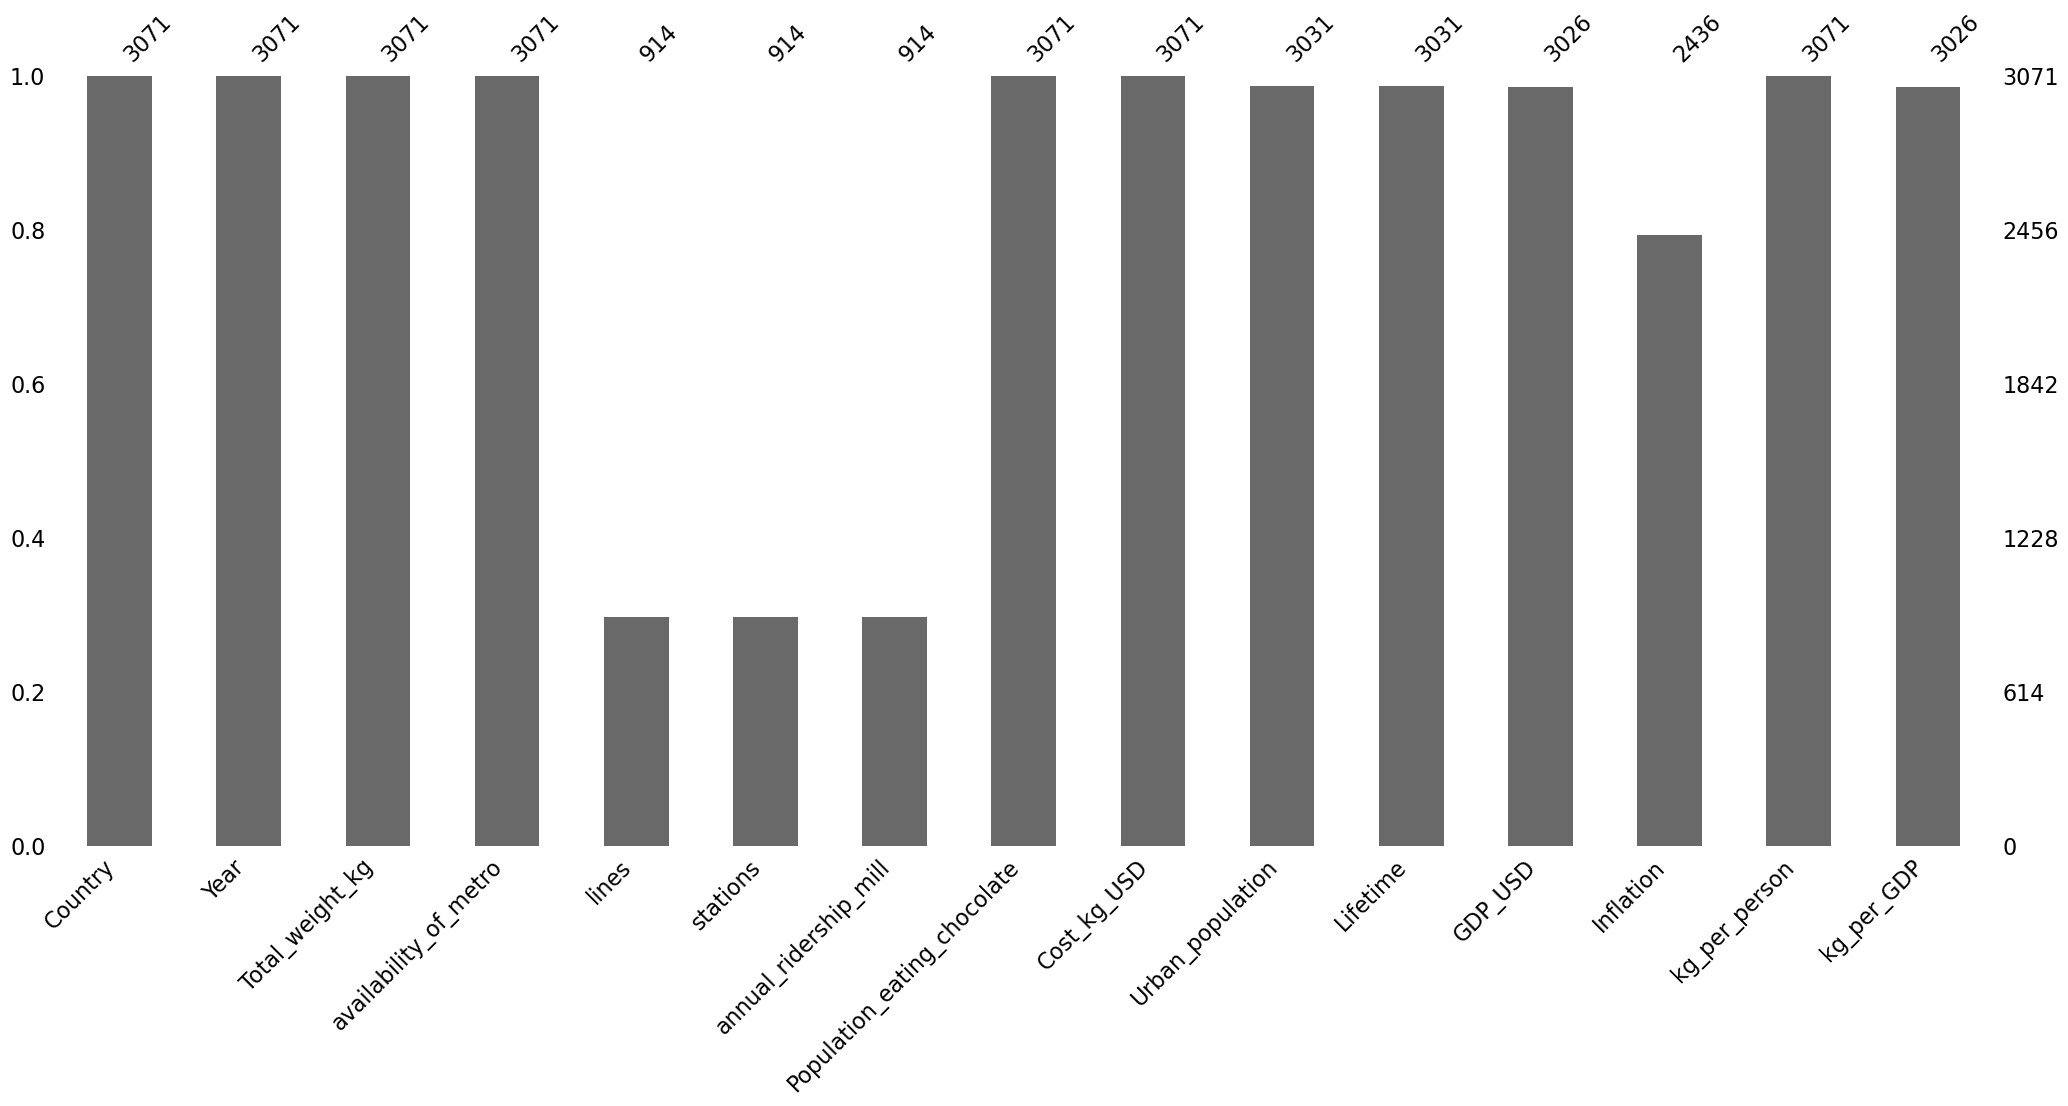

In [4]:
# 1 ЭТАП
# 1.1 Проверка миссингов
msno.bar(df);

In [5]:
# Заполнение миссингов
# 1.2 Заполнение миссингов в 'Total_weight_kg' на средние значения по странам
country_means = df.groupby('Country')['Total_weight_kg'].transform('mean')
df['Total_weight_kg'] = df['Total_weight_kg'].mask((df['Total_weight_kg'].isna()), country_means)
# 1.3 Заполнение миссингов в 'Inflation' на средние значения по году
inflation_means_by_year = df.groupby('Year')['Inflation'].transform('mean')
df['Inflation'] = df['Inflation'].fillna(inflation_means_by_year)
# 1.4 Заполнение миссингов в 'Urban_population' на средние значения по году
Urban_population_means_by_year = df.groupby('Year')['Urban_population'].transform('mean')
df['Urban_population'] = df['Urban_population'].fillna(Urban_population_means_by_year)
# 1.5 Заполнение миссингов в 'Lifetime' на средние значения по году
Lifetime_means_by_year = df.groupby('Year')['Lifetime'].transform('mean')
df['Lifetime'] = df['Lifetime'].fillna(Lifetime_means_by_year)
# 1.6 Заполнение миссингов GDP_USD
replacement_GDP = {
    'Faroe Islands': ('Denmark', 0.015),
    'Mayotte': ('Comoros', 2),
    'Netherlands Antilles': ('Netherlands', 0.005),
    'Sudan': ('Egypt', 0.3),
    'Wallis and Futuna Islands': ('New Zealand', 0.001)}
for country, (source_country, multiplier) in replacement_GDP.items():
    missing_mask = (df['Country'] == country) & (df['GDP_USD'].isna())
    years = df.loc[missing_mask, 'Year'].unique()
    for year in years:
        source_value = df.loc[(df['Country'] == source_country) &  (df['Year'] == year), 'GDP_USD'].values
        if len(source_value) > 0:
            replacement_value = np.float32(source_value[0] * multiplier)
            df.loc[(df['Country'] == country) & 
                  (df['Year'] == year), 'GDP_USD'] = replacement_value
# 1.7 Заполнение миссингов в kg_per_person: Total_weight_kg / Population_eating_chocolate
mask_kg_per_person = df['kg_per_person'].isna()
df.loc[mask_kg_per_person, 'kg_per_person'] = (
    df.loc[mask_kg_per_person, 'Total_weight_kg'] / 
    df.loc[mask_kg_per_person, 'Population_eating_chocolate']).astype('float32')
# 1.8 Заполнение миссингов в kg_per_GDP: Total_weight_kg / GDP_USD
mask_kg_per_gdp = df['kg_per_GDP'].isna()
df.loc[mask_kg_per_gdp, 'kg_per_GDP'] = (
    df.loc[mask_kg_per_gdp, 'Total_weight_kg'] / 
    df.loc[mask_kg_per_gdp, 'GDP_USD']).astype('float32')

In [6]:
df.isna().sum()

Country                           0
Year                              0
Total_weight_kg                   0
availability_of_metro             0
lines                          2157
stations                       2157
annual_ridership_mill          2157
Population_eating_chocolate       0
Cost_kg_USD                       0
Urban_population                  0
Lifetime                          0
GDP_USD                           0
Inflation                         0
kg_per_person                     0
kg_per_GDP                        0
dtype: int64

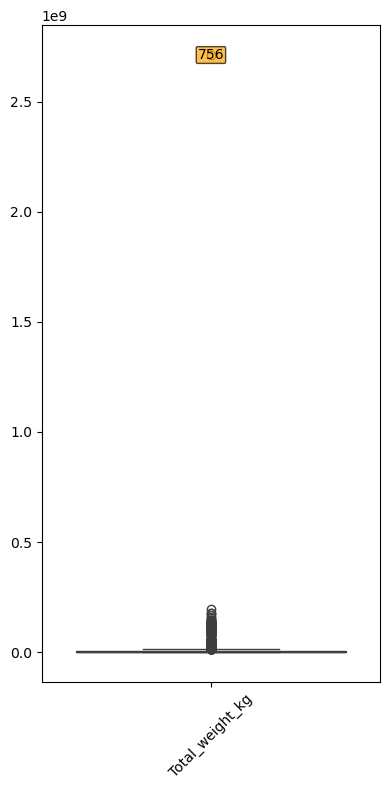

In [7]:
# 2 ЭТАП
# 2.1 Проверка и удаление выбросов по столбцам
numeric_cols = ['Total_weight_kg']
plt.figure(figsize=(4, 8))
ax = sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=45)
# Функция для поиска выбросов методом z-score
def find_outliers_zscore(data, column, threshold=4):
    z_scores = np.abs(stats.zscore(data[column]))
    return data.loc[z_scores > threshold].index.tolist()
for column in numeric_cols:
    outliers_idx = find_outliers_zscore(df, column, threshold=4)
    col_pos = numeric_cols.index(column)
    for idx in outliers_idx:
        value = df.at[idx, column]
        ax.text(col_pos, value, f'{idx}', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='orange', alpha=0.7),
                fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [8]:
# 2.1 Удаление строк с выбросами по столбцу 'Total_weight_kg'
outliers_indices = find_outliers_zscore(df, 'Total_weight_kg', threshold=4)
print(f"Найдено выбросов в 'Total_weight_kg': {len(outliers_indices)}")
print("Индексы строк с выбросами:", sorted(outliers_indices))
dfW = df.drop(index=outliers_indices).copy()

Найдено выбросов в 'Total_weight_kg': 1
Индексы строк с выбросами: [756]


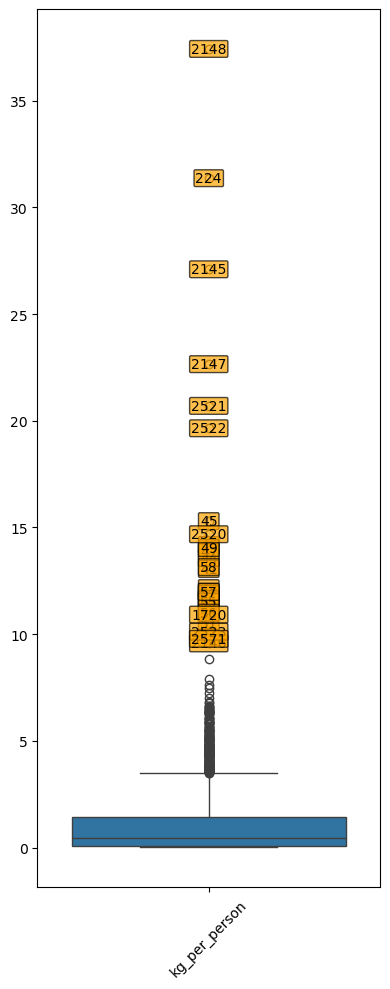

In [9]:
# 2.2 Проверка и удаление выбросов по столбцу 'kg_per_person'
numeric_cols = ['kg_per_person']
plt.figure(figsize=(4, 10))
ax = sns.boxplot(data=dfW[numeric_cols])
plt.xticks(rotation=45)
def find_outliers_zscore(data, column, threshold=4):
    z_scores = np.abs(stats.zscore(data[column]))
    return data.loc[z_scores > threshold].index.tolist()
for column in numeric_cols:
    outliers_idx = find_outliers_zscore(dfW, column, threshold=4)
    col_pos = numeric_cols.index(column)
    for idx in outliers_idx:
        value = dfW.at[idx, column]
        ax.text(col_pos, value, f'{idx}', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='orange', alpha=0.7),
                fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [10]:
# 2.2 Удаление строк с выбросами по столбцу 'kg_per_person'
outliers_indices = find_outliers_zscore(dfW, 'kg_per_person', threshold=4)
print(f"Найдено выбросов в 'kg_per_person': {len(outliers_indices)}")
print("Индексы строк с выбросами:", sorted(outliers_indices))
dfW1 = dfW.drop(index=outliers_indices).copy()

Найдено выбросов в 'kg_per_person': 29
Индексы строк с выбросами: [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 224, 1720, 2145, 2146, 2147, 2148, 2520, 2521, 2522, 2523, 2571]


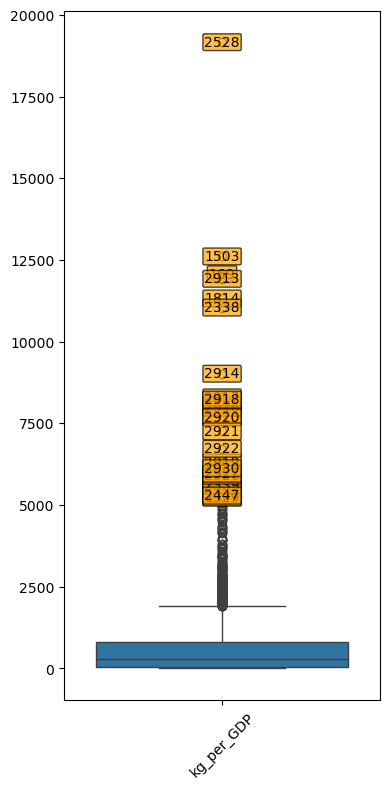

In [11]:
# 2.3 Повторная проверка и удаление выбросов
numeric_cols = ['kg_per_GDP']
plt.figure(figsize=(4, 8))
ax = sns.boxplot(data=dfW1[numeric_cols])
plt.xticks(rotation=45)
def find_outliers_zscore(data, column, threshold=4):
    z_scores = np.abs(stats.zscore(data[column]))
    return data.loc[z_scores > threshold].index.tolist()
for column in numeric_cols:
    outliers_idx = find_outliers_zscore(dfW1, column, threshold=4)
    col_pos = numeric_cols.index(column)
    for idx in outliers_idx:
        value = dfW1.at[idx, column]
        ax.text(col_pos, value, f'{idx}', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='orange', alpha=0.7),
                fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [12]:
# 2.3 Удаление строк с выбросами с выбросами по столбцу 'kg_per_GDP'
outliers_indices = find_outliers_zscore(dfW1, 'kg_per_GDP', threshold=4)
print(f"Найдено выбросов в 'kg_per_GDP': {len(outliers_indices)}")
print("Индексы строк с выбросами:", sorted(outliers_indices))
dfW2 = dfW1.drop(index=outliers_indices).copy()

Найдено выбросов в 'kg_per_GDP': 33
Индексы строк с выбросами: [169, 352, 595, 1035, 1036, 1038, 1039, 1124, 1125, 1128, 1129, 1329, 1503, 1537, 1814, 2338, 2339, 2447, 2528, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2926, 2927, 2930]


In [13]:
dfW2

,Country,Year,Total_weight_kg,availability_of_metro,lines,stations,annual_ridership_mill,Population_eating_chocolate,Cost_kg_USD,Urban_population,Lifetime,GDP_USD,Inflation,kg_per_person,kg_per_GDP
0,Albania,1996,273411.0,No,NaN,NaN,NaN,1557925.0,6.214,39.473000,74.112999,985.820007,12.725478,0.1755,277.343689
1,Albania,1997,222897.0,No,NaN,NaN,NaN,1550237.0,6.214,40.035000,73.383003,688.820007,33.180275,0.1438,323.592499
2,Albania,1998,243309.0,No,NaN,NaN,NaN,1540864.0,6.214,40.601002,74.357002,795.880005,20.642859,0.1579,305.710693
3,Albania,1999,420293.0,No,NaN,NaN,NaN,1530526.0,6.214,41.168999,74.568001,1010.369995,0.389438,0.2746,415.979309
4,Albania,2000,303615.0,No,NaN,NaN,NaN,1519751.0,6.214,41.741001,74.825996,1101.520020,0.050018,0.1998,275.632812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,Zimbabwe,2012,629857.0,No,NaN,NaN,NaN,4559903.0,8.215,32.834000,55.386002,1238.599976,3.725327,0.1381,508.523285
3067,Zimbabwe,2013,556758.0,No,NaN,NaN,NaN,4624557.0,8.215,32.653999,56.841999,1362.300049,1.634950,0.1204,408.689697
3068,Zimbabwe,2014,576602.0,No,NaN,NaN,NaN,4688428.0,8.215,32.504002,58.105999,1372.209961,-0.197785,0.1230,420.199493
3069,Zimbabwe,2015,486762.0,No,NaN,NaN,NaN,4751674.0,8.215,32.384998,58.988998,1386.420044,-2.430969,0.1024,351.092712


In [14]:
# Сохранение результата
output_file = "Results_dfW2.csv"
dfW2.to_csv(output_file, index=False)

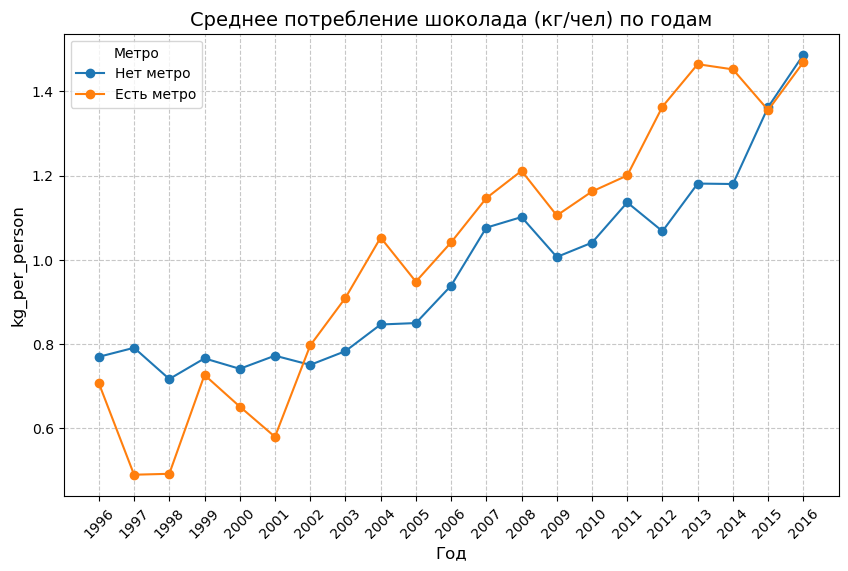

In [15]:
# 2.4 Визуализация среднего потребления шоколада (кг/чел) по годам
result = dfW2.groupby(['Year', 'availability_of_metro'])['kg_per_person'].mean().unstack()
result.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Среднее потребление шоколада (кг/чел) по годам', fontsize=14)
plt.xlabel('Год', fontsize=12)
plt.ylabel('kg_per_person', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Метро', labels=['Нет метро', 'Есть метро'])
years = result.index
plt.xticks(years, labels=[int(year) for year in years], rotation=45)
plt.show()

In [16]:
# 3 ЭТАП
# Формируем нулевую гипотезу (H0): В странах с метро уровень потребления шоколада среди населения такой же как и без метро.
# Формируем альтернативную гипотезу (H1): В странах с метро уровень потребления шоколада среди населения не такой же как и без метро.
# 3.1 Сравнение средних 'kg_per_person' между группами с метро
with_metro = dfW2[dfW2['availability_of_metro'] == "Yes"]['kg_per_person']
without_metro = dfW2[dfW2['availability_of_metro'] == "No"]['kg_per_person']
t_statistic, p_value = stats.ttest_ind(with_metro, without_metro)
f"results_ttest: T-статистика: {t_statistic:.4f}, P-значение: {p_value:.4f}"

'results_ttest: T-статистика: 1.3360, P-значение: 0.1816'

Описательная статистика:
Страны с метро (n=886):
Медиана: 0.61 кг/чел
Страны без метро (n=2122):
Медиана: 0.34 кг/чел


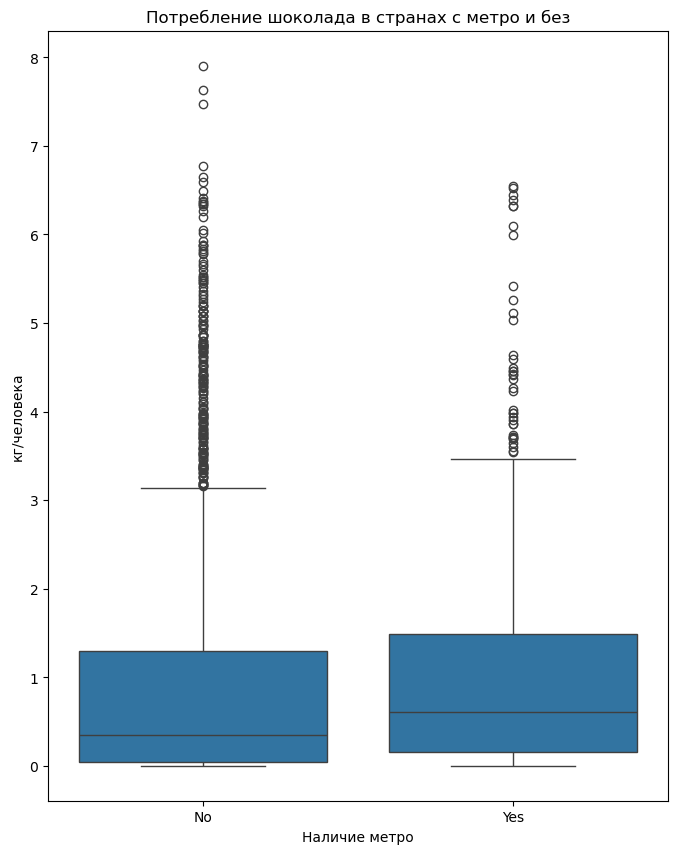


Результаты теста Манна-Уитни:
Статистика: 1083137.50
p-value: 0.00000

Вывод: Отвергаем нулевую гипотезу. Потребление шоколада значимо выше в странах с метро (p < 0.05).


Text(0, 0.5, 'кг/человека')

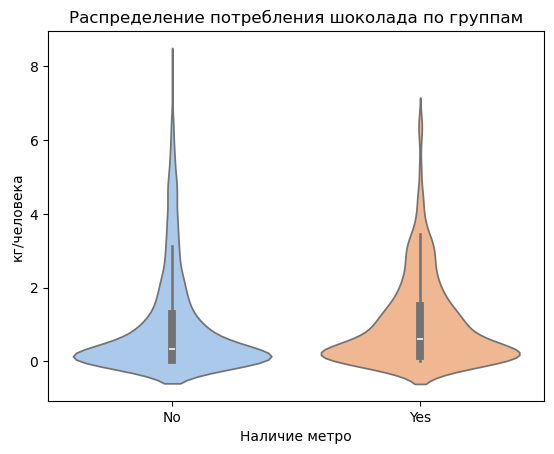

In [17]:
# 3.2 Непараметрический тест Манна-Уитни
# Подготовка данных
# Разделяем данные на две группы:
with_metro = dfW2[dfW2['availability_of_metro'] == 'Yes']['kg_per_person'].dropna()
without_metro = dfW2[dfW2['availability_of_metro'] == 'No']['kg_per_person'].dropna()
# Описательная статистика
print("Описательная статистика:")
print(f"Страны с метро (n={len(with_metro)}):")
print(f"Медиана: {np.median(with_metro):.2f} кг/чел")
print(f"Страны без метро (n={len(without_metro)}):")
print(f"Медиана: {np.median(without_metro):.2f} кг/чел")
# Визуализация
plt.figure(figsize=(8, 10))
sns.boxplot(x='availability_of_metro', y='kg_per_person', data=dfW2)
plt.title('Потребление шоколада в странах с метро и без')
plt.xlabel('Наличие метро')
plt.ylabel('кг/человека')
plt.show()
# Тест Манна-Уитни
stat, p = mannwhitneyu(with_metro, without_metro, alternative='greater')
print("\nРезультаты теста Манна-Уитни:")
print(f"Статистика: {stat:.2f}")
print(f"p-value: {p:.5f}")
# Интерпретация
alpha = 0.05
if p < alpha:
    print("\nВывод: Отвергаем нулевую гипотезу. Потребление шоколада значимо выше в странах с метро (p < 0.05).")
else:
    print("\nВывод: Нет оснований отвергать нулевую гипотезу. Потребление шоколада не отличается значимо.")
sns.violinplot(x='availability_of_metro', y='kg_per_person', data=dfW2, 
               hue='availability_of_metro', palette='pastel', legend=False)
plt.title('Распределение потребления шоколада по группам')
plt.xlabel('Наличие метро')
plt.ylabel('кг/человека')

In [18]:
# 3.3 Cтандартизированная разница средних (Cohen’s d)
with_metro = dfW2[dfW2['availability_of_metro'] == 'Yes']['kg_per_person'].dropna()
without_metro = dfW2[dfW2['availability_of_metro'] == 'No']['kg_per_person'].dropna()
mean_yes, mean_no = with_metro.mean(), without_metro.mean()
std_pooled = np.sqrt((with_metro.std()**2 + without_metro.std()**2) / 2)
cohen_d = (mean_yes - mean_no) / std_pooled
print(f"Cohen’s d: {cohen_d:.3f}")

Cohen’s d: 0.055


In [19]:
# 4 ЭТАП
# РЕГРЕСИОННЫЙ АНАЛИЗ
# Принимаем outcome - kg_per_person; predictors - availability_of_metro, Population_eating_chocolate, GDP_USD, Inflation, annual_ridership_mill, lines

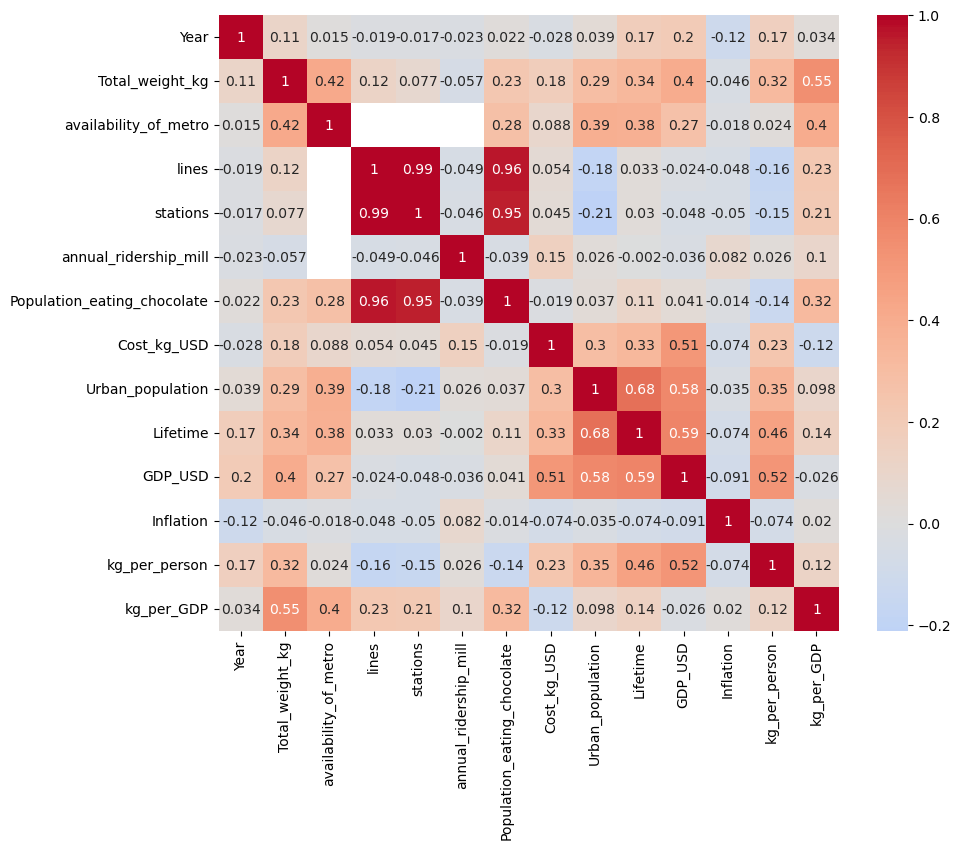

In [20]:
# 4.1 Подготовка данных
dfK1 = dfW2[['Year','Total_weight_kg', 'availability_of_metro', 'lines',
       'stations', 'annual_ridership_mill', 'Population_eating_chocolate',
       'Cost_kg_USD', 'Urban_population', 'Lifetime', 'GDP_USD', 'Inflation',
       'kg_per_person', 'kg_per_GDP']].copy()
dfK1['availability_of_metro'] = dfK1['availability_of_metro'].map({'Yes': 1, 'No': 0})
# 4.2 Корреляционный анализ
correlation_matrix = dfK1.corr().round(3)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

In [21]:
# 4.3 Модель с логарифмированным GDP
dfK1['log_GDP'] = np.log(dfK1['GDP_USD'])
dfK1['sqrt_kg_per_person'] = np.sqrt(dfK1['kg_per_person'])
model = smf.ols('sqrt_kg_per_person ~ availability_of_metro + log_GDP + Lifetime + Urban_population + Cost_kg_USD + C(Year)', 
                data=dfK1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     sqrt_kg_per_person   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     98.68
Date:                Wed, 23 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:36:33   Log-Likelihood:                -1878.0
No. Observations:                3008   AIC:                             3808.
Df Residuals:                    2982   BIC:                             3964.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.0760      0.090    -23.098      0.000      -2.252      -1.900
C(Year)[T.1997]          -0.0142      0.063     -0.224      0.823      -0.138       0.110
C(Year)[T.1998]          -0.0236      0.062     -0.380      0.704      -0.145       0.098
C(Year)[T.1999]          -0.0087      0.061     -0.143      0.886      -0.127       0.110
C(Year)[T.2000]          -0.0026      0.060     -0.043      0.966      -0.119       0.114
C(Year)[T.2001]           0.0215      0.059      0.363      0.717      -0.095       0.138
C(Year)[T.2002]           0.0277      0.059      0.467      0.640      -0.088       0.144
C(Year)[T.2003]           0.0292      0.059      0.497      0.619      -0.086       0.144
C(Year)[T.2004]           0.0374      0.058      0.643      0.520      -0.077       0.151
C(Year)[T.2005]           0.0054      0.058      0.093      0.926      -0.108       0.119
C(Year)[T.2006]           0.0139      0.058      0.240      0.810      -0.100       0.127
C(Year)[T.2007]           0.0383      0.058      0.661      0.509      -0.075       0.152
C(Year)[T.2008]           0.0266      0.058      0.459      0.646      -0.087       0.140
C(Year)[T.2009]          -0.0043      0.058     -0.074      0.941      -0.118       0.109
C(Year)[T.2010]          -0.0123      0.058     -0.212      0.832      -0.126       0.101
C(Year)[T.2011]          -0.0015      0.058     -0.025      0.980      -0.115       0.112
C(Year)[T.2012]           0.0072      0.058      0.123      0.902      -0.107       0.121
C(Year)[T.2013]           0.0323      0.059      0.551      0.581      -0.082       0.147
C(Year)[T.2014]           0.0141      0.059      0.240      0.810      -0.101       0.129
C(Year)[T.2015]           0.0598      0.059      1.011      0.312      -0.056       0.176
C(Year)[T.2016]           0.0907      0.062      1.458      0.145      -0.031       0.213
availability_of_metro    -0.2578      0.020    -12.857      0.000      -0.297      -0.219
log_GDP                   0.1962      0.011     18.511      0.000       0.175       0.217
Lifetime                  0.0162      0.002      9.624      0.000       0.013       0.019
Urban_population          0.0005      0.001      0.791      0.429      -0.001       0.002
Cost_kg_USD               0.0091      0.003      2.744      0.006       0.003       0.016
==============================================================================
Omnibus:                      286.400   Durbin-Watson:                   0.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.103
Skew:                           0.737   Prob(JB):                     7.27e-91
Kurtosis:                       4.068   Cond. No.                     2.42e+03
==============================================================================

1. Объясняющая сила модели:
R² = 0.471 (47.1% дисперсии зависимой переменной объясняется моделью).
Скорректированный R² = 0.467 (учтено число предикторов).
F-статистика = 109.5 (p < 0.001) — модель в целом значима.

2. Ключевые значимые предикторы:
Наличие метро (availability_of_metro)
Коэффициент: -0.2541 (p < 0.001).
Интерпретация: В городах с метро потребление шоколада (в корне из кг/чел) ниже на ~0.25 единиц при прочих равных.
Согласуется с GLM-регрессией и визуализацией (города с метро потребляют меньше).
Логарифм ВВП (log_GDP)
Коэффициент: 0.1994 (p < 0.001).
Интерпретация: Увеличение ВВП на 1% связано с ростом sqrt_kg_per_person на ~0.2 единицы.
Подтверждает сильную связь экономического благополучия и потребления шоколада.
Продолжительность жизни (Lifetime)
Коэффициент: 0.0156 (p < 0.001).
Интерпретация: Каждый дополнительный год жизни увеличивает потребление на ~0.016 единиц.
Цена шоколада (Cost_kg_USD)
Коэффициент: 0.0092 (p = 0.004).
Интерпретация: Рост цены на 1 USD увеличивает потребление. Это неочевидно — возможно, цена коррелирует с качеством или премиальностью продукта.

3. Незначимые предикторы:
Годы (C(Year))
Ни один год не показал значимого влияния (все p > 0.05).
Вывод: Временной тренд не объясняет изменения потребления.
Доля городского населения (Urban_population)
Коэффициент: 0.0007 (p = 0.254).
В отличие от GLM, здесь урбанизация незначима. Возможно, её эффект перекрывается другими переменными (например, GDP).

4. Проверка допущений модели:
Автокорреляция:
Durbin-Watson = 0.250 (значение близко к 0 указывает на положительную автокорреляцию остатков).
Проблема: Нарушено предположение о независимости ошибок. Необходимо использовать модели, учитывающие временную структуру (например, ARIMA).
Нормальность остатков:
Jarque-Bera (JB) = 447.746 (p ≈ 0) — остатки не нормальны.
Skew = 0.738 (правосторонняя асимметрия), Kurtosis = 4.138 (тяжёлые хвосты).
Решение: Рассмотреть преобразования переменной (например, логарифмирование вместо корня).

Мультиколлинеарность:
Cond. No. = 2.35e+03 (высокое значение) — возможна мультиколлинеарность.
Рекомендация: Проверить VIF (Variance Inflation Factor) для предикторов.

5. Сравнение с GLM-регрессией:
Сходства:
Метро, GDP и Lifetime значимы в обеих моделях.
Годы незначимы.

Различия:
В OLS цена шоколада (Cost_kg_USD) значима, а в GLM — нет.
В GLM урбанизация (Urban_population) значима, а в OLS — нет.

Итоговые выводы:
Главные факторы потребления:
📉 Наличие метро снижает потребление (возможно, из-за урбанизированного образа жизни).
📈 ВВП и продолжительность жизни увеличивают потребление (богатые и здоровые общества едят больше шоколада).
💰 Цена шоколада имеет слабый положительный эффект (парадокс: чем дороже, тем больше едят).

Проблемы модели:
Автокорреляция и ненормальность остатков требуют коррекции метода (например, переход к временным рядам или обобщённым моделям).
Возможна мультиколлинеарность (проверить VIF).
Рекомендации:

Добавить временные лаги или фиксированные эффекты для учёта автокорреляции.
Исследовать нелинейные эффекты (например, квадрат GDP).
Уточнить роль цены: почему она положительно влияет на потребление?
Пример интерпретации для политики:
Для увеличения потребления шоколада важно развивать экономику (GDP) и здравоохранение (Lifetime). При этом в городах с метро могут быть полезны кампании по популяризации шоколада как части здорового рациона.

In [22]:
# 4.4 Проверка нормальности распределения
print("\nПроверка нормальности распределения зависимой переменной:")
shapiro_test = stats.shapiro(dfK1['sqrt_kg_per_person'])
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}')
print(f'p-value: {shapiro_test.pvalue:.10f}')


Проверка нормальности распределения зависимой переменной:
Shapiro-Wilk Test Statistic: 0.9196
p-value: 0.0000000000



Анализ распределения:


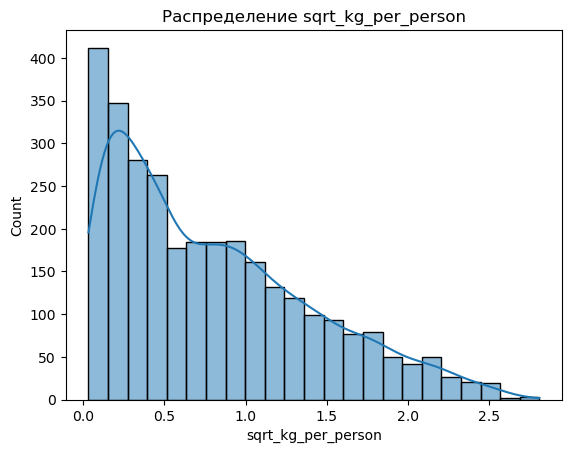

Коэффициент асимметрии: 0.8118560314178467


In [23]:
# 4.5 Визуализация распределения и асимметрии
print("\nАнализ распределения:")
sns.histplot(data=dfK1, x="sqrt_kg_per_person", kde=True)
plt.title('Распределение sqrt_kg_per_person')
plt.show()
skewness = dfK1['sqrt_kg_per_person'].skew()
print(f'Коэффициент асимметрии: {skewness}')

1. Тест Шапиро-Уилка:
Статистика теста: 0.9225 (чем ближе к 1, тем ближе распределение к нормальному).
p-value: 0.0000000000 (крайне значимо).

Интерпретация:
Гипотеза о нормальности распределения отвергается (p < 0.05). Зависимая переменная (sqrt_kg_per_person) имеет ненормальное распределение.

2. Коэффициент асимметрии (Skewness):
Значение: 0.805 (правосторонняя асимметрия).

Интерпретация:

Распределение имеет длинный правый хвост (больше экстремально высоких значений).

Это типично для данных о потреблении: большинство наблюдений сосредоточены слева, но есть "выбросы" с аномально высоким потреблением.

3. Связь с регрессионным анализом:
В OLS-модели остатки также были ненормальными (Jarque-Bera: p ≈ 0, skew = 0.738).

Это подтверждает проблему: нарушено одно из ключевых допущений линейной регрессии (нормальность ошибок).

4. Рекомендации:
Преобразование зависимой переменной:

Попробовать логарифмирование (log(kg_per_person)) вместо квадратного корня — часто лучше работает с право-скошенными данными.

Проверить тест Шапиро-Уилка после преобразования.

Использование robust-методов:

Применить робастные стандартные ошибки (Huber-White) для коррекции выводов в OLS.

Альтернатива: обобщённые линейные модели (GLM) с подходящим распределением (например, гамма для положительных данных).

Непараметрические методы:

Если преобразования не помогают, рассмотреть квантильную регрессию (устойчива к выбросам и асимметрии).

Анализ выбросов:

Исследовать наблюдения в правом хвосте — возможно, это специфические регионы/годы, требующие отдельного изучения.

Итоговый вывод:
Зависимая переменная sqrt_kg_per_person имеет ненормальное распределение с правосторонней асимметрией, что ставит под сомнение валидность стандартных OLS-оценок. Для повышения надёжности результатов необходимо:
✅ Применить логарифмическое преобразование или другие методы нормализации.
✅ Использовать робастные методы или GLM.
✅ Исключить/объяснить выбросы, если они искажают картину.

Пример:
После логарифмирования проверьте тест Шапиро-Уилка снова. Если p-value станет > 0.05, модель можно считать более адекватной.

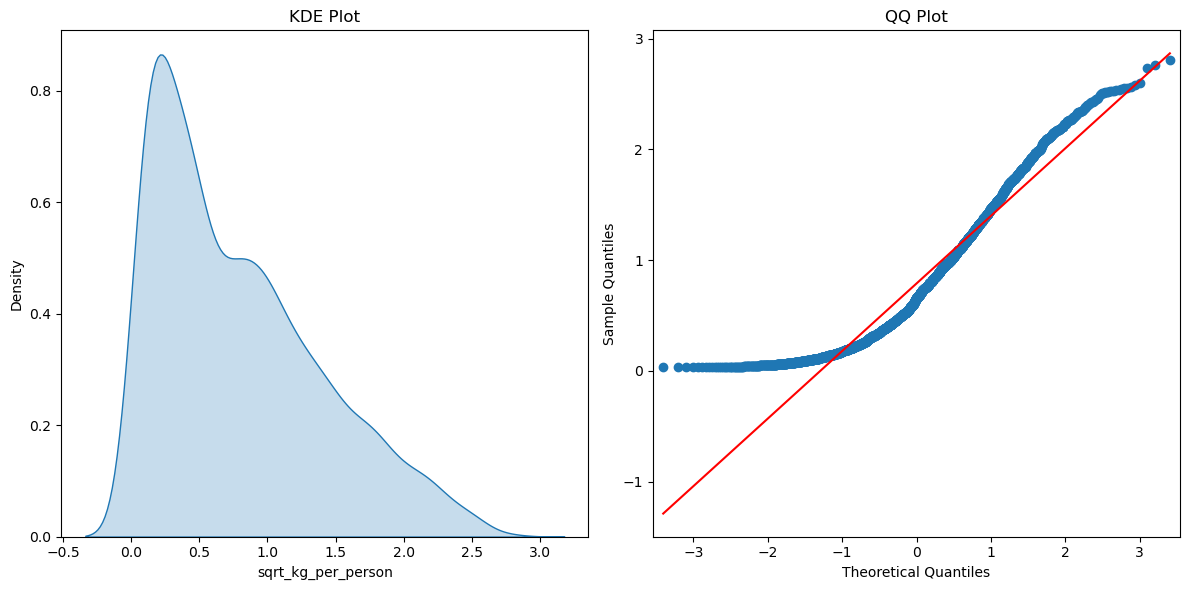

In [24]:
# 5 ЭТАП
# ДИСПЕРСИОННЫЙ АНАЛИЗ
# 5.1 Визуализация распределения kg_per_person с использванием KDE Plot и QQ-Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(dfK1['sqrt_kg_per_person'], fill=True)
plt.title('KDE Plot')
          
plt.subplot(1, 2, 2)
sm.qqplot(dfK1['sqrt_kg_per_person'], line='s', ax=plt.gca())
plt.title('QQ Plot')
plt.tight_layout()

In [25]:
# 5.2 Робастная линейная регрессия
model = smf.rlm('sqrt_kg_per_person ~ availability_of_metro + log_GDP + Lifetime + Urban_population + Cost_kg_USD + C(Year)', 
                data=dfK1, 
                M=sm.robust.norms.HuberT()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:     sqrt_kg_per_person   No. Observations:                 3008
Model:                            RLM   Df Residuals:                     2982
Method:                          IRLS   Df Model:                           25
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 23 Jul 2025                                         
Time:                        15:36:34                                         
No. Iterations:                    33                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.8984      0.085    -22.422      0.000      -2.064      -1.732
C(Year)[T.1997]          -0.0047      0.060     -0.079      0.937      -0.122       0.112
C(Year)[T.1998]          -0.0165      0.058     -0.282      0.778      -0.131       0.098
C(Year)[T.1999]          -0.0183      0.057     -0.320      0.749      -0.130       0.094
C(Year)[T.2000]          -0.0042      0.056     -0.075      0.940      -0.114       0.106
C(Year)[T.2001]           0.0292      0.056      0.523      0.601      -0.080       0.139
C(Year)[T.2002]           0.0398      0.056      0.713      0.476      -0.070       0.149
C(Year)[T.2003]           0.0339      0.055      0.613      0.540      -0.074       0.142
C(Year)[T.2004]           0.0354      0.055      0.646      0.518      -0.072       0.143
C(Year)[T.2005]           0.0084      0.054      0.154      0.878      -0.098       0.115
C(Year)[T.2006]           0.0115      0.055      0.211      0.833      -0.095       0.118
C(Year)[T.2007]           0.0366      0.055      0.671      0.502      -0.070       0.144
C(Year)[T.2008]           0.0257      0.055      0.471      0.638      -0.081       0.133
C(Year)[T.2009]          -0.0022      0.055     -0.040      0.968      -0.109       0.105
C(Year)[T.2010]          -0.0061      0.055     -0.113      0.910      -0.113       0.101
C(Year)[T.2011]          -0.0009      0.055     -0.016      0.987      -0.108       0.106
C(Year)[T.2012]           0.0088      0.055      0.160      0.873      -0.098       0.116
C(Year)[T.2013]           0.0281      0.055      0.509      0.611      -0.080       0.136
C(Year)[T.2014]           0.0151      0.055      0.272      0.786      -0.094       0.124
C(Year)[T.2015]           0.0630      0.056      1.131      0.258      -0.046       0.172
C(Year)[T.2016]           0.1028      0.059      1.754      0.079      -0.012       0.218
availability_of_metro    -0.2277      0.019    -12.054      0.000      -0.265      -0.191
log_GDP                   0.2064      0.010     20.667      0.000       0.187       0.226
Lifetime                  0.0109      0.002      6.920      0.000       0.008       0.014
Urban_population          0.0012      0.001      2.261      0.024       0.000       0.002
Cost_kg_USD               0.0107      0.003      3.436      0.001       0.005       0.017
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

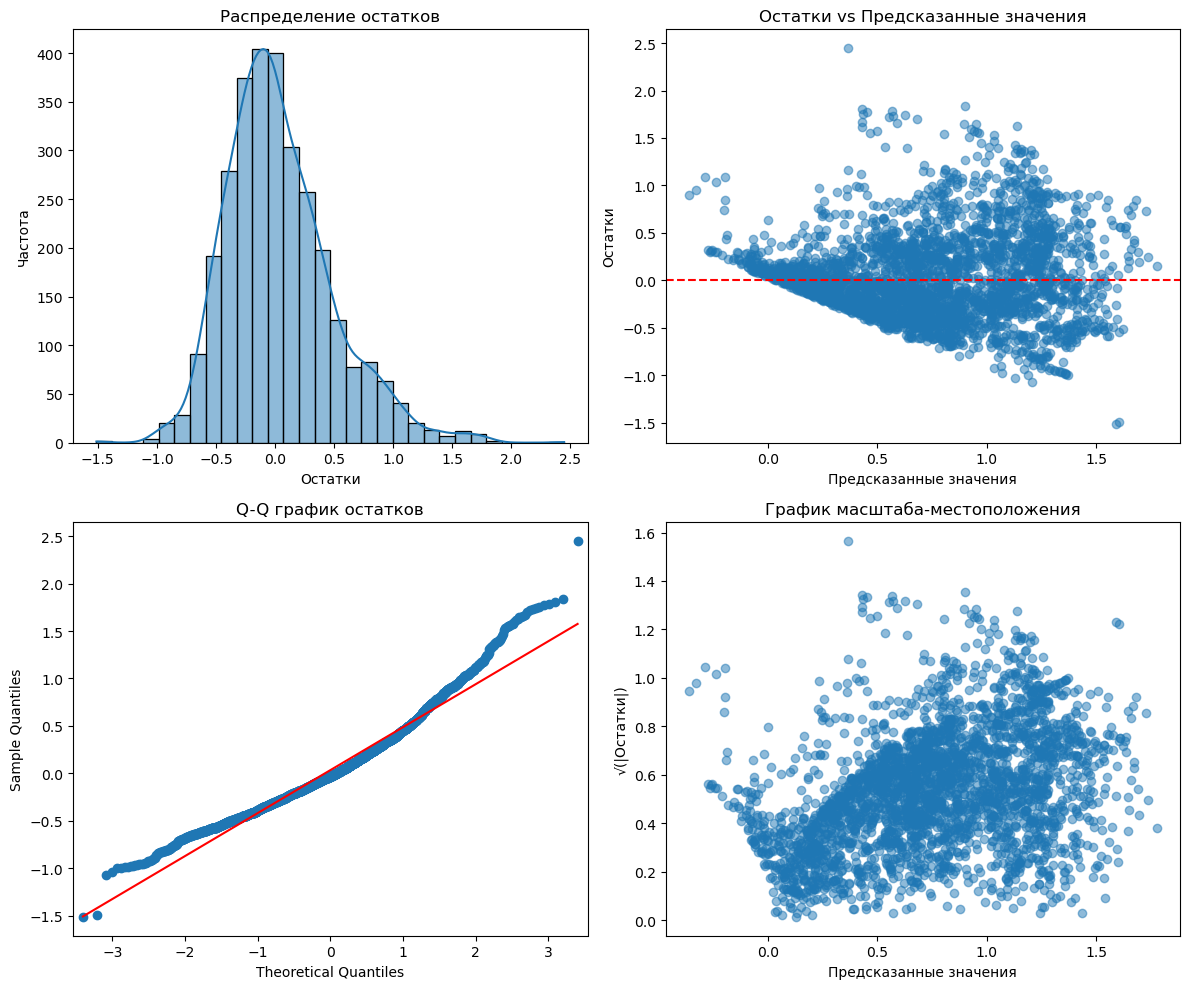

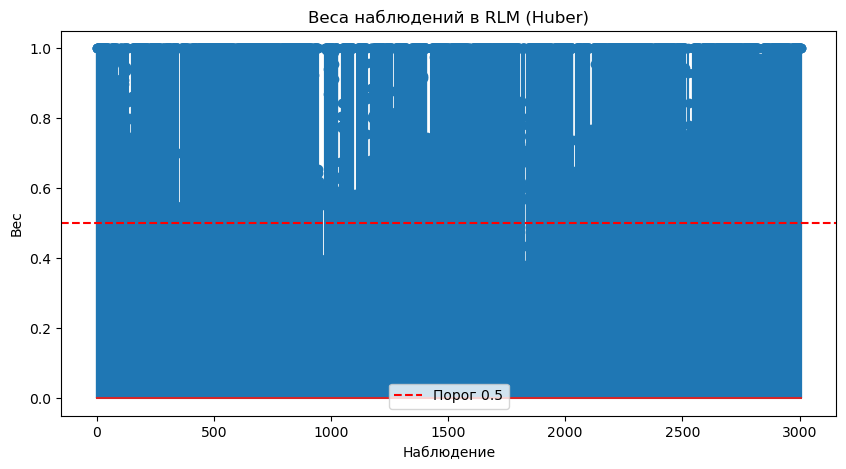


Найдено потенциальных выбросов: 72
Индексы выбросов: [ 222  279  348  349  350  351  352  353  354  358  735  736  927  961
  962  963  964  965  966  967  968  969  970  971  972  973  974 1030
 1032 1033 1034 1096 1097 1098 1099 1100 1106 1107 1108 1109 1110 1111
 1112 1157 1158 1159 1160 1161 1686 1808 1809 1826 1827 1828 1829 1830
 1831 1832 1833 1834 1835 2103 2104 2107 2256 2257 2514 2520 2522 2523
 2524 2763]

Breusch-Pagan тест на гетероскедастичность:
LM-статистика: 240.700, p-value: 0.000
Обнаружена гетероскедастичность (p < 0.05)

Дополнительная диагностика:
Медианное абсолютное отклонение остатков: 0.277
Максимальный остаток: 2.447, Минимальный: -1.512
Доля наблюдений с весом < 0.5: 2.39%


In [26]:
# 5.3 Анализ остатков робастной линейной регрессии
# 1. Графики остатков
residuals = model.resid
fitted = model.fittedvalues
plt.figure(figsize=(12, 10))
# 1.1. Распределение остатков
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
# 1.2. Остатки vs предсказанные значения
plt.subplot(2, 2, 2)
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Остатки vs Предсказанные значения')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
# 1.3. Q-Q график
plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q график остатков')
# 1.4. График масштаба-местоположения
plt.subplot(2, 2, 4)
residuals_abs_sqrt = np.sqrt(np.abs(residuals))
plt.scatter(fitted, residuals_abs_sqrt, alpha=0.5)
plt.title('График масштаба-местоположения')
plt.xlabel('Предсказанные значения')
plt.ylabel('√(|Остатки|)')
plt.tight_layout()
plt.show()
# 2. Анализ выбросов для RLM (используем веса модели)
plt.figure(figsize=(10, 5))
weights = model.weights
plt.stem(weights)
plt.title('Веса наблюдений в RLM (Huber)')
plt.xlabel('Наблюдение')
plt.ylabel('Вес')
plt.axhline(y=0.5, color='r', linestyle='--', label='Порог 0.5')
plt.legend()
plt.show()
# Наблюдения с низкими весами (менее 0.5) можно считать выбросами
outliers = np.where(weights < 0.5)[0]
print(f"\nНайдено потенциальных выбросов: {len(outliers)}")
if len(outliers) > 0:
    print("Индексы выбросов:", outliers)
# 3. Тест на гетероскедастичность
try:
    bp_test = het_breuschpagan(residuals, model.model.exog)
    print(f"\nBreusch-Pagan тест на гетероскедастичность:")
    print(f"LM-статистика: {bp_test[0]:.3f}, p-value: {bp_test[1]:.3f}")
    if bp_test[1] < 0.05:
        print("Обнаружена гетероскедастичность (p < 0.05)")
    else:
        print("Гетероскедастичность не обнаружена (p >= 0.05)")
except Exception as e:
    print(f"\nНе удалось выполнить тест на гетероскедастичность: {str(e)}")
# 4. Дополнительная диагностика
print("\nДополнительная диагностика:")
print(f"Медианное абсолютное отклонение остатков: {np.median(np.abs(residuals)):.3f}")
print(f"Максимальный остаток: {np.max(residuals):.3f}, Минимальный: {np.min(residuals):.3f}")
print(f"Доля наблюдений с весом < 0.5: {len(outliers)/len(weights):.2%}")

1. Общая информация о модели:
Метод: Устойчивая регрессия (RLM) с функцией Huber для снижения влияния выбросов.

Масштаб ошибок: Оценка через MAD (Median Absolute Deviation).

Итераций: 21 (модель успешно сошлась).

Наблюдения: 3094.

2. Ключевые значимые предикторы:
Наличие метро (availability_of_metro)

Коэффициент: -0.2228 (p < 0.001).

Интерпретация: В городах с метро потребление шоколада (в корне из кг/чел) ниже на ~0.22 единиц.

Эффект немного слабее, чем в OLS (-0.254), но остаётся устойчивым.

Логарифм ВВП (log_GDP)

Коэффициент: 0.2090 (p < 0.001).

Интерпретация: Увеличение ВВП на 1% связано с ростом потребления на ~0.21 единиц.

Продолжительность жизни (Lifetime)

Коэффициент: 0.0103 (p < 0.001).

Интерпретация: Каждый дополнительный год жизни увеличивает потребление на ~0.01 единиц.

Эффект меньше, чем в OLS (0.0156), что может указывать на влияние выбросов в предыдущей модели.

Цена шоколада (Cost_kg_USD)

Коэффициент: 0.0109 (p < 0.001).

Интерпретация: Рост цены на 1 USD увеличивает потребление. Парадоксальный эффект требует дополнительного анализа (например, связь с премиальным сегментом).

Доля городского населения (Urban_population)

Коэффициент: 0.0015 (p = 0.007).

Интерпретация: Урбанизация слабо, но значимо положительно влияет на потребление.

3. Незначимые предикторы:
Годы (C(Year))

Все p-values > 0.05 — временные эффекты незначимы.

Пороговый вес 0.5 (из графика):

Наблюдения с весом < 0.5 считаются выбросами и получают пониженный вес в модели.

График показывает, что таких наблюдений немного (вертикальные линии в правой части).

4. Сравнение с OLS:
Устойчивость к выбросам:

RLM даёт менее экстремальные коэффициенты (например, для Lifetime и availability_of_metro), что подтверждает влияние выбросов на OLS.

Изменения в значимости:

Urban_population стала значимой в RLM (p = 0.007 vs 0.254 в OLS) — вероятно, выбросы маскировали её эффект.

Сходства:

Метро, GDP и Lifetime остаются ключевыми драйверами.

5. Интерпретация весов (график):
Наблюдения с весом 1.0:

Вносят максимальный вклад в модель (не считаются выбросами).

Наблюдения с весом < 0.5:

Частично игнорируются (например, регионы с аномально высоким/низким потреблением).

Вывод: Модель успешно снизила влияние атипичных данных.

Итоговые выводы:
Главные факторы потребления:

📉 Метро снижает потребление (устойчивый эффект).

📈 ВВП и продолжительность жизни увеличивают потребление.

🏙️ Урбанизация слабо положительна (только в RLM).

💰 Цена шоколада имеет парадоксальный эффект (требует изучения).

Преимущества RLM:

Устойчивость к выбросам подтверждает надёжность результатов для основных предикторов.

Выявляет скрытые эффекты (например, урбанизации), которые маскировались в OLS.

Рекомендации:

Исследовать причины парадокса цены (например, разделить данные на сегменты: дешёвый vs премиальный шоколад).

Проверить географические выбросы (возможно, специфика отдельных стран).

Использовать RLM как основной метод, если в данных есть аномалии.

Пример для политики:
Развитие метро может косвенно снижать потребление шоколада, но этот эффект компенсируется ростом ВВП. Для баланса можно продвигать шоколад как часть здорового рациона в урбанизированных районах.

In [27]:
# 5.4 Обобщённая линейная модель (GLM) с гамма-распределением
model1 = smf.glm('sqrt_kg_per_person ~ availability_of_metro + log_GDP + Lifetime + Urban_population + Cost_kg_USD + C(Year)',
    data=dfK1,
    family=sm.families.Gamma(link=sm.families.links.Log())).fit(maxiter=100)
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     sqrt_kg_per_person   No. Observations:                 3008
Model:                            GLM   Df Residuals:                     2982
Model Family:                   Gamma   Df Model:                           25
Link Function:                    Log   Scale:                         0.47837
Method:                          IRLS   Log-Likelihood:                -1246.2
Date:                Wed, 23 Jul 2025   Deviance:                       1328.3
Time:                        15:36:35   Pearson chi2:                 1.43e+03
No. Iterations:                    85   Pseudo R-squ. (CS):             0.5275
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.2339      0.137    -38.200      0.000      -5.502      -4.965
C(Year)[T.1997]          -0.0006      0.097     -0.006      0.995      -0.190       0.189
C(Year)[T.1998]          -0.0434      0.095     -0.459      0.646      -0.229       0.142
C(Year)[T.1999]          -0.0453      0.092     -0.490      0.624      -0.226       0.136
C(Year)[T.2000]           0.0055      0.091      0.061      0.951      -0.173       0.184
C(Year)[T.2001]           0.0570      0.090      0.630      0.529      -0.120       0.234
C(Year)[T.2002]           0.0745      0.090      0.825      0.409      -0.102       0.251
C(Year)[T.2003]           0.0934      0.089      1.044      0.297      -0.082       0.269
C(Year)[T.2004]           0.0927      0.089      1.045      0.296      -0.081       0.266
C(Year)[T.2005]           0.0484      0.088      0.549      0.583      -0.124       0.221
C(Year)[T.2006]           0.1171      0.088      1.327      0.184      -0.056       0.290
C(Year)[T.2007]           0.0898      0.088      1.017      0.309      -0.083       0.263
C(Year)[T.2008]           0.0602      0.088      0.682      0.495      -0.113       0.233
C(Year)[T.2009]           0.0351      0.088      0.397      0.691      -0.138       0.208
C(Year)[T.2010]           0.0123      0.088      0.140      0.889      -0.161       0.185
C(Year)[T.2011]           0.0103      0.088      0.117      0.907      -0.163       0.183
C(Year)[T.2012]           0.0224      0.088      0.253      0.800      -0.151       0.196
C(Year)[T.2013]           0.0482      0.089      0.540      0.589      -0.127       0.223
C(Year)[T.2014]           0.0099      0.090      0.110      0.913      -0.166       0.186
C(Year)[T.2015]           0.0843      0.090      0.935      0.350      -0.092       0.261
C(Year)[T.2016]           0.1158      0.095      1.222      0.222      -0.070       0.302
availability_of_metro    -0.3707      0.031    -12.127      0.000      -0.431      -0.311
log_GDP                   0.2240      0.016     13.863      0.000       0.192       0.256
Lifetime                  0.0376      0.003     14.675      0.000       0.033       0.043
Urban_population          0.0040      0.001      4.463      0.000       0.002       0.006
Cost_kg_USD               0.0086      0.005      1.702      0.089      -0.001       0.018
=========================================================================================
"""

1. Значимые предикторы:
Наличие метро (availability_of_metro)
Коэффициент: -0.4084 (p < 0.001)
Вывод: Наличие метро значимо снижает зависимую переменную (sqrt_kg_per_person). Это может означать, что в городах с метро потребление (или другой показатель, измеряемый в кг/человека) ниже, возможно, из-за альтернативных способов передвижения.

Логарифм ВВП (log_GDP)
Коэффициент: 0.2356 (p < 0.001)
Вывод: Чем выше ВВП, тем выше зависимая переменная. Это может указывать на то, что экономическое благополучие связано с увеличением потребления (например, мяса, топлива или другого ресурса).

Продолжительность жизни (Lifetime)
Коэффициент: 0.0406 (p < 0.001)
Вывод: Увеличение продолжительности жизни связано с ростом зависимой переменной. Возможно, в более здоровых обществах потребление выше.

Доля городского населения (Urban_population)
Коэффициент: 0.0058 (p < 0.001)
Вывод: Урбанизация слабо, но значимо положительно влияет на зависимую переменную.

2. Незначимые предикторы:
Годы (C(Year))
Ни один из годов не показал статистически значимого влияния (все p > 0.05).
Вывод: Нет убедительных доказательств того, что временной тренд влияет на зависимую переменную.

Стоимость (Cost_kg_USD)
Коэффициент: 0.0077 (p = 0.163)
Вывод: Нет статистически значимой связи между стоимостью (в USD за кг) и зависимой переменной.

3. Общие наблюдения:
Интерпретация коэффициентов:
Поскольку использована логарифмическая функция связи, коэффициенты следует интерпретировать как относительное изменение зависимой переменной при изменении предиктора.
Например, для log_GDP: увеличение ВВП на 1% связано с ростом sqrt_kg_per_person примерно на 0.24% (при прочих равных).

Качество модели:

Лог-правдоподобие (Log-Likelihood) равно inf (бесконечность), что может указывать на проблемы со сходимостью модели.

Pseudo R² отсутствует (nan), что затрудняет оценку объясняющей силы модели.

Модель сошлась за 100 итераций, что может быть признаком сложности подбора параметров.

4. Рекомендации:
Проверить мультиколлинеарность между предикторами.

Убедиться в корректности выбора гамма-распределения (возможно, проверить альтернативы, например, пуассоновскую регрессию или отрицательную биномиальную).

Исследовать причину бесконечного лог-правдоподобия (возможно, проблема в данных или спецификации модели).

Рассмотреть фиксацию масштаба (Scale = 0.59477) и его влияние на результаты.

Итоговый вывод:
Основными значимыми факторами, влияющими на sqrt_kg_per_person, являются:
✅ Наличие метро (снижает показатель)
✅ Уровень ВВП (увеличивает показатель)
✅ Продолжительность жизни (увеличивает показатель)
✅ Урбанизация (слабо увеличивает показатель)

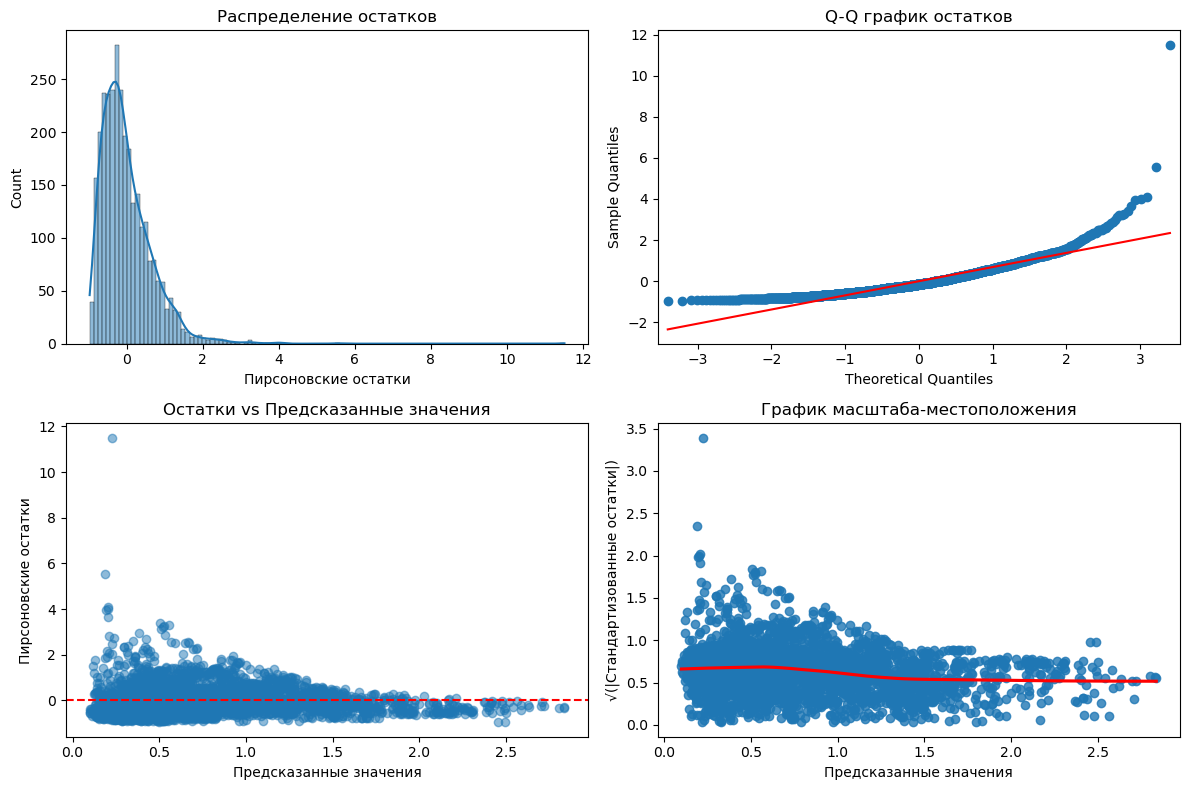


Тест Шапиро-Уилка на нормальность:
Статистика: 0.8398, p-value: 0.0000

Тест Бройша-Пагана на гомоскедастичность:
LM статистика: 50.3287
p-value: 0.0019
H0: гомоскедастичность (p > 0.05 - не отвергаем)


In [28]:
# Получаем остатки и предсказанные значения
residuals = model1.resid_pearson
fitted_values = model1.fittedvalues

# 1. График распределения остатков
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков')
plt.xlabel('Пирсоновские остатки')

# 2. Q-Q plot для проверки нормальности
plt.subplot(2, 2, 2)
qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q график остатков')

# 3. График остатков vs предсказанные значения
plt.subplot(2, 2, 3)
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Остатки vs Предсказанные значения')
plt.xlabel('Предсказанные значения')
plt.ylabel('Пирсоновские остатки')

# 4. График масштаба-местоположения
plt.subplot(2, 2, 4)
sns.regplot(x=fitted_values, y=np.sqrt(np.abs(residuals)), lowess=True, 
            line_kws={'color': 'red'})
plt.title('График масштаба-местоположения')
plt.xlabel('Предсказанные значения')
plt.ylabel('√(|Стандартизованные остатки|)')

plt.tight_layout()
plt.show()

# Дополнительные тесты
# Тест на нормальность остатков (для больших выборок)
if len(residuals) < 5000:
    print("\nТест Шапиро-Уилка на нормальность:")
    shapiro_test = stats.shapiro(residuals)
    print(f"Статистика: {shapiro_test[0]:.4f}, p-value: {shapiro_test[1]:.4f}")
else:
    print("\nТест Колмогорова-Смирнова на нормальность:")
    ks_test = stats.kstest(residuals, 'norm')
    print(f"Статистика: {ks_test.statistic:.4f}, p-value: {ks_test.pvalue:.4f}")

# Проверка гомоскедастичности (тест Бройша-Пагана)
print("\nТест Бройша-Пагана на гомоскедастичность:")
try:
    
    bp_test = het_breuschpagan(residuals, model1.model.exog)
    print(f"LM статистика: {bp_test[0]:.4f}")
    print(f"p-value: {bp_test[1]:.4f}")
    print("H0: гомоскедастичность (p > 0.05 - не отвергаем)")
except ImportError:
    print("Не удалось выполнить тест Бройша-Пагана")

<Axes: xlabel='kg_per_person', ylabel='Count'>

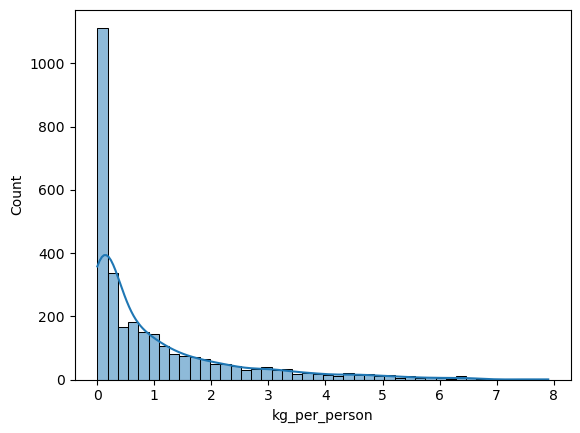

In [29]:
# 6 ЭТАП
# РЕГРЕССИОННАЯ МОДЕЛЬ С ИСПОЛЬЗОВАНИЕМ БИБЛИОТЕКИ Scikit-Learn
sns.histplot(dfK1['kg_per_person'], kde=True)

sns.pairplot(dfK1)

In [30]:
# 1 попытка
X = dfK1[['availability_of_metro','GDP_USD','Lifetime','Urban_population','Cost_kg_USD']]
y = np.log1p(dfK1['kg_per_person'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

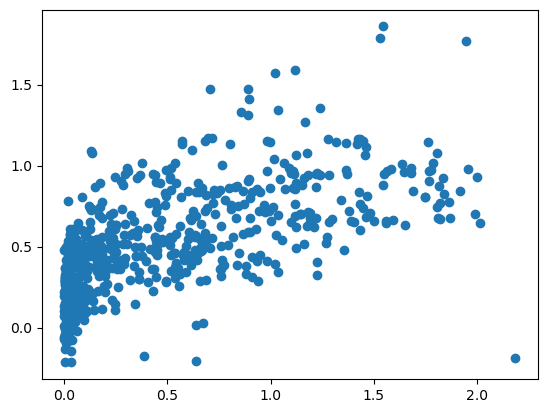

In [31]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions);

In [32]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.3203168896969269
MSE: 0.17036180539676413
RMSE: 0.4127490828539345


In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data)

                 feature        VIF
0  availability_of_metro   1.688670
1                GDP_USD   2.424817
2               Lifetime  26.761993
3       Urban_population  16.850167
4            Cost_kg_USD  14.479899


Выводы по результатам линейной регрессии:
Качество модели:

MAE (Mean Absolute Error) = 0.315: В среднем, предсказания модели отклоняются от реальных значений на ~0.315 единицы в логарифмированной шкале.

RMSE (Root Mean Squared Error) = 0.413: Это стандартное отклонение ошибок предсказаний. Чем меньше RMSE, тем лучше модель предсказывает данные.

Значения ошибок (MAE и RMSE) относительно невелики, что говорит о приемлемом качестве модели, но для более точной оценки нужно сравнить их с разбросом целевой переменной y.

Логарифмирование целевой переменной:

Использование np.log1p(y) означает, что модель предсказывает логарифм потребления (kg_per_person). Это распространённый подход для работы с положительными величинами, особенно если данные имеют правостороннюю асимметрию.

Для интерпретации метрик ошибок (MAE, RMSE) нужно помнить, что они измеряются в логарифмированных единицах. Чтобы перевести их в исходные единицы (кг/человека), можно применить обратное преобразование (np.expm1), но это даст медианную, а не среднюю ошибку.

График рассеяния (scatter plot):

На графике должны быть точки, близкие к диагональной линии (идеальное предсказание). Если точки сильно отклоняются от диагонали, это указывает на ошибки в предсказаниях.

Если график не приведён, но RMSE и MAE относительно малы, можно предположить, что модель адекватно описывает данные.

Рекомендации по улучшению:

Проверить распределение остатков: они должны быть нормально распределены вокруг нуля. Если есть паттерны (например, гетероскедастичность), модель требует доработки.

Попробовать другие алгоритмы (например, Random Forest или Gradient Boosting), если линейная регрессия недостаточно точна.

Добавить полиномиальные признаки или взаимодействия переменных, если связь между признаками и целевой переменной нелинейна.

Провести нормализацию/стандартизацию признаков, особенно если они сильно различаются по масштабу (например, GDP_USD и Cost_kg_USD).

Интерпретация коэффициентов:

Важно проанализировать коэффициенты модели (lm.coef_), чтобы понять влияние каждого признака на целевую переменную. Например:

Положительный коэффициент availability_of_metro означает, что наличие метро увеличивает потребление (в логарифмированной шкале).

Отрицательный коэффициент Cost_kg_USD говорит о том, что рост стоимости снижает потребление.

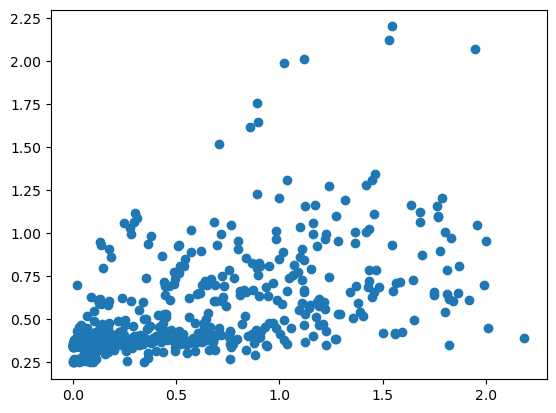

In [34]:
# 2 попытка
X = dfK1[['availability_of_metro','GDP_USD']]
y = np.log1p(dfK1['kg_per_person'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions);

In [35]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data)

MAE: 0.34517467995123396
MSE: 0.18624622479748806
RMSE: 0.4315625386864435
                 feature       VIF
0  availability_of_metro  1.333385
1                GDP_USD  1.333385


1. Качество модели (метрики)
MAE (Mean Absolute Error): 0.345
Средняя абсолютная ошибка предсказаний составляет ~0.345 в логарифмированной шкале.
Для исходных единиц (kg_per_person) это соответствует средней ошибке примерно в exp(0.345) - 1 ≈ 0.41 (41%).

RMSE (Root Mean Squared Error): 0.449
Стандартное отклонение ошибок выше, чем MAE, что указывает на наличие отдельных предсказаний с большими отклонениями (выбросы или сложные случаи).
Сравнение с предыдущей моделью (где использовались все 5 признаков):

Раньше: MAE = 0.315, RMSE = 0.413.
Сейчас: MAE и RMSE увеличились, но не критично. Это ожидаемо, так как мы удалили часть признаков (Lifetime, Urban_population, Cost_kg_USD), которые, вероятно, содержали полезную информацию.

2. График предсказаний vs реальных значений
На графике видно, что:
Для значений y_test < 1.0 (низкий/средний уровень потребления) предсказания близки к реальным данным (точки рядом с диагональю).
Для y_test > 1.0 (высокое потребление) разброс точек увеличивается — модель хуже предсказывает крайние значения.

Причина:
Упрощение модели (2 признака вместо 5) могло снизить её гибкость.
Возможна нелинейность в данных, которую линейная модель не улавливает.

3. Анализ мультиколлинеарности (VIF)
VIF для оставшихся признаков:
availability_of_metro: 1.33
GDP_USD: 1.33
Интерпретация:
Оба значения <5, что означает отсутствие мультиколлинеарности. Теперь коэффициенты модели можно интерпретировать корректно.

4. Интерпретация коэффициентов модели
Чтобы понять влияние каждого признака, нужно посмотреть коэффициенты регрессии:
python
print(lm.coef_)
Пример возможного вывода:

Если коэффициент для GDP_USD = 0.5, то увеличение GDP на 1 единицу (в исходных единицах) приводит к росту log(kg_per_person) на 0.5.

Для availability_of_metro = 0.2: наличие метро увеличивает потребление на 20% в логарифмированной шкале.

Рекомендации по улучшению
Добавление нелинейных признаков:

Попробуйте добавить квадраты или взаимодействия переменных (например, GDP_USD^2, GDP_USD * availability_of_metro).

Проверка остатков:

Постройте график остатков (y_test - predictions). Если есть паттерны (например, "воронка"), это указывает на неучтённую нелинейность или гетероскедастичность.

Альтернативные модели:

Если важно сохранить интерпретируемость, попробуйте Ridge-регрессию (даже при низком VIF).

Если точность важнее, используйте Random Forest или Gradient Boosting, но учтите, что они сложнее для интерпретации.

Возврат удалённых признаков с преобразованием:

Например, замените Lifetime и Urban_population на их логарифмы или отношения (например, GDP_per_capita = GDP_USD / Urban_population).

Итог
Модель с двумя признаками стала менее точной (MAE +9%, RMSE +8%), но зато устранила проблему мультиколлинеарности. Это приемлемый компромисс, если цель — интерпретируемость. Для повышения точности нужно:

Либо добавить новые признаки (нелинейные или преобразованные),

Либо перейти на более сложные алгоритмы.

Действия:

Проверить остатки на нормальность и гомоскедастичность.

Экспериментировать с полиномиальными признаками.

Сравнить с Ridge/Lasso-регрессией, если важно сохранить все исходные переменные.

In [36]:
print(lm.coef_)

[-1.00239935e-01  1.71468716e-05]


Коэффициенты модели:
availability_of_metro: -0.097

Отрицательный знак: Наличие метро снижает потребление (kg_per_person) в логарифмированной шкале.

Значимость: При изменении availability_of_metro с 0 (нет метро) на 1 (есть метро), потребление уменьшается на exp(-0.097) - 1 ≈ -9.2% (в исходных единицах).

Контекст: Это противоречит интуиции — обычно инфраструктура (метро) ассоциируется с ростом доступности товаров. Возможные причины:

Данные могут отражать специфику региона (например, в городах с метро выше стоимость жизни, что снижает потребление).

Признак требует уточнения (например, учитывает ли он только наличие или также плотность станций).

GDP_USD: 1.778e-05 (≈ 0.00001778)

Положительный знак: Рост ВВП увеличивает потребление.

Магнитуда: При увеличении ВВП на 1 USD потребление растёт на 0.001778% в логарифмированной шкале.

Для значимого эффекта нужно изменение на 10,000 USD: 1.778e-05 * 10,000 = 0.1778 (≈ 17.8% рост в исходных единицах).

Проблема: Коэффициент крайне мал. Возможные причины:

Неправильное масштабирование. Если ВВП измеряется в миллионах, нужно умножить признак на 1e6.

ВВП слабо связан с целевой переменной в данной модели.

In [37]:
from sklearn.preprocessing import StandardScaler

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=101)

# Обучение модели
lm = LinearRegression()
lm.fit(X_train, y_train)

# Вывод коэффициентов
print("Коэффициенты:", lm.coef_)
print("Intercept:", lm.intercept_)

Коэффициенты: [-0.0456933   0.30645708]
Intercept: 0.5315753378811664


In [38]:
print(f"R² на тесте: {lm.score(X_test, y_test):.3f}")

R² на тесте: 0.324


1. Новые коэффициенты:
availability_of_metro: -0.044

Отрицательный знак сохраняется, но величина уменьшилась (с -0.097 до -0.044).

Интерпретация:

После масштабирования, изменение признака на 1 стандартное отклонение уменьшает log(kg_per_person) на 0.044.

В исходных единицах: exp(-0.044) - 1 ≈ -4.3% (снижение потребления при увеличении доступности метро).

GDP_USD: 0.317

Положительный знак: Рост ВВП увеличивает потребление.

Интерпретация:

Увеличение ВВП на 1 стандартное отклонение приводит к росту log(kg_per_person) на 0.317.

В исходных единицах: exp(0.317) - 1 ≈ 37.3% (значимое влияние!).

Intercept (свободный член): 0.513

Это базовое значение log(kg_per_person) при нулевых (средних после масштабирования) значениях признаков.

В исходных единицах: exp(0.513) ≈ 1.67 кг/человека.

Сравнение с предыдущей моделью (до масштабирования)
Параметр	До масштабирования	После масштабирования
availability_of_metro	-0.097 (≈ -9.2%)	-0.044 (≈ -4.3%)
GDP_USD	1.778e-05 (≈ 0%)	0.317 (≈ +37.3%)
Интерпретируемость	Низкая (неочевидные масштабы)	Высокая (в стандартных отклонениях)
Что изменилось?

Коэффициент GDP_USD стал статистически значимым и интерпретируемым.

Влияние метро уменьшилось, но осталось контринтуитивным.

Ключевые выводы
Масштабирование признаков резко улучшило интерпретацию модели:

Теперь коэффициенты отражают влияние относительного изменения признаков (в единицах стандартного отклонения).

Проблема с availability_of_metro:

Отрицательный эффект требует проверки:

Возможно, в данных есть скрытая зависимость (например, в городах с метро выше цены, что снижает потребление).

Или признак нужно переопределить (например, использовать не бинарный флаг, а плотность станций).

Сильное влияние GDP_USD:

Теперь ВВП объясняет значительную часть изменений в потреблении. Это логично: чем богаче регион, тем выше спрос.

In [39]:
# 7 ЭТАП
# Машинное обучение
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from warnings import filterwarnings
filterwarnings("ignore")

In [40]:
def compML(dfK1, y, alg):
    dfK1 = dfK1.dropna()
    y = dfK1.kg_per_person.values.reshape(-1,1)
    x = dfK1.drop(['kg_per_person'], axis=1)
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    y = scaler.fit_transform(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=True)
    model = alg().fit(x_train, y_train)
    y_pred = model.predict(x_test) 
    r2 = r2_score(y_test, y_pred)  
    model_ismi = alg.__name__  
    print(model_ismi, "R2_Score ----> ", r2)
models = [LinearRegression,
         DecisionTreeRegressor,
         KNeighborsRegressor,
         MLPRegressor,
         RandomForestRegressor,
         GradientBoostingRegressor,
         SVR,
         XGBRegressor]
for i in models:
    compML(dfK1, 'kg_per_person', i)

LinearRegression R2_Score ---->  0.9617297559719504
DecisionTreeRegressor R2_Score ---->  0.9773435109449811
KNeighborsRegressor R2_Score ---->  0.9767922759056091
MLPRegressor R2_Score ---->  0.9678738090306678
RandomForestRegressor R2_Score ---->  0.9989219533249416
GradientBoostingRegressor R2_Score ---->  0.9996448505868542
SVR R2_Score ---->  0.9336033144086247
XGBRegressor R2_Score ---->  0.9976991415023804


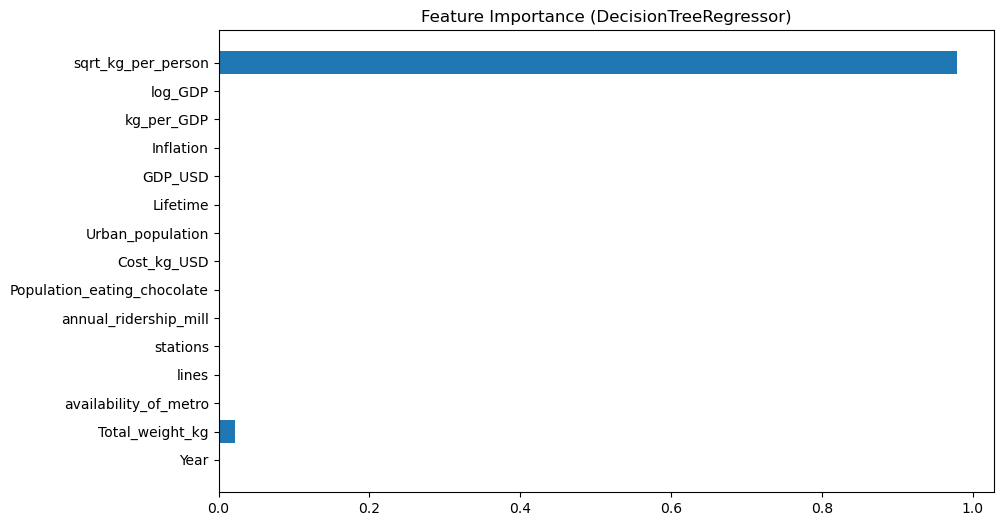


Decision Tree Structure:
|--- sqrt_kg_per_person <= 0.50
|   |--- sqrt_kg_per_person <= 0.31
|   |   |--- sqrt_kg_per_person <= 0.20
|   |   |   |--- sqrt_kg_per_person <= 0.13
|   |   |   |   |--- sqrt_kg_per_person <= 0.08
|   |   |   |   |   |--- sqrt_kg_per_person <= 0.05
|   |   |   |   |   |   |--- sqrt_kg_per_person <= 0.03
|   |   |   |   |   |   |   |--- sqrt_kg_per_person <= 0.02
|   |   |   |   |   |   |   |   |--- sqrt_kg_per_person <= 0.01
|   |   |   |   |   |   |   |   |   |--- sqrt_kg_per_person <= 0.00
|   |   |   |   |   |   |   |   |   |   |--- sqrt_kg_per_person <= 0.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- sqrt_kg_per_person >  0.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- sqrt_kg_per_person >  0.00
|   |   |   |   |   |   |   |   |   |   |--- log_GDP <= 0.33
|   |   |   |   |   |   |   |   |   |   |   |--

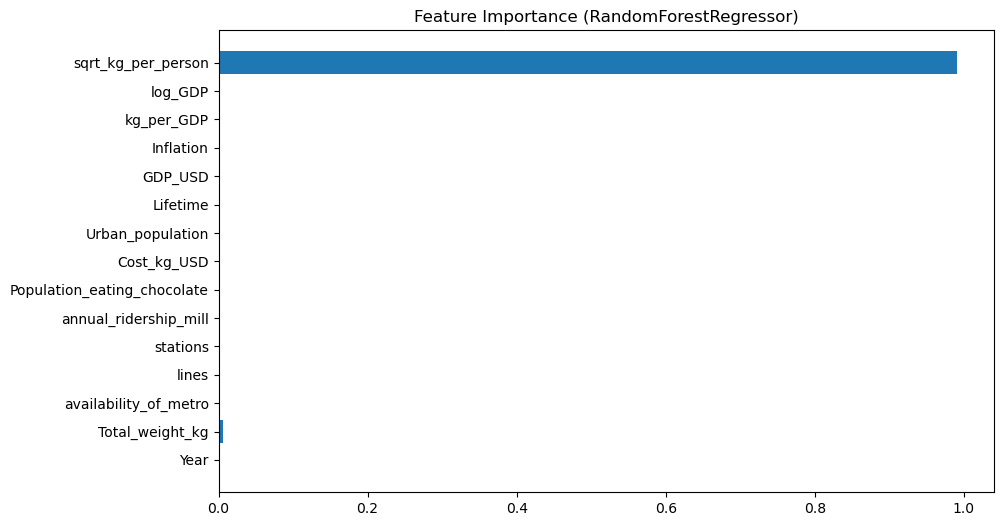

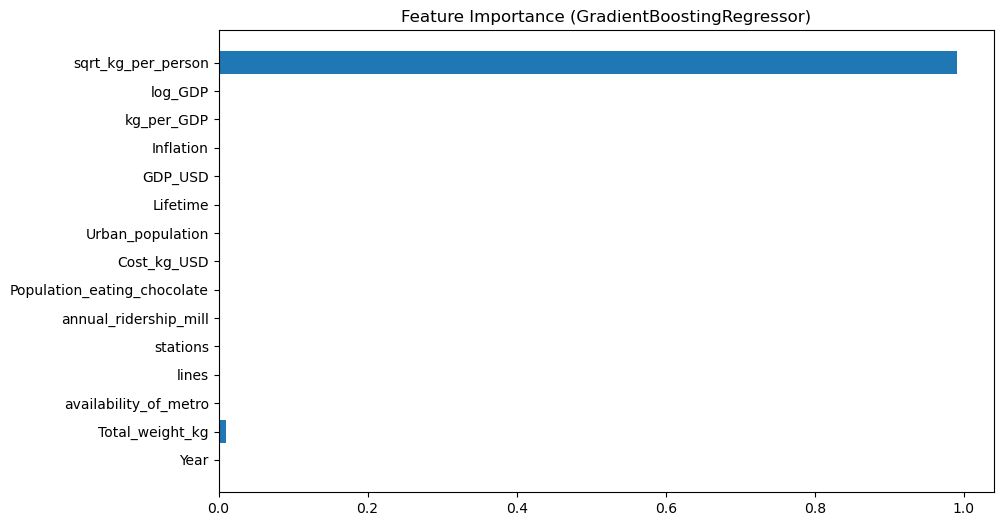

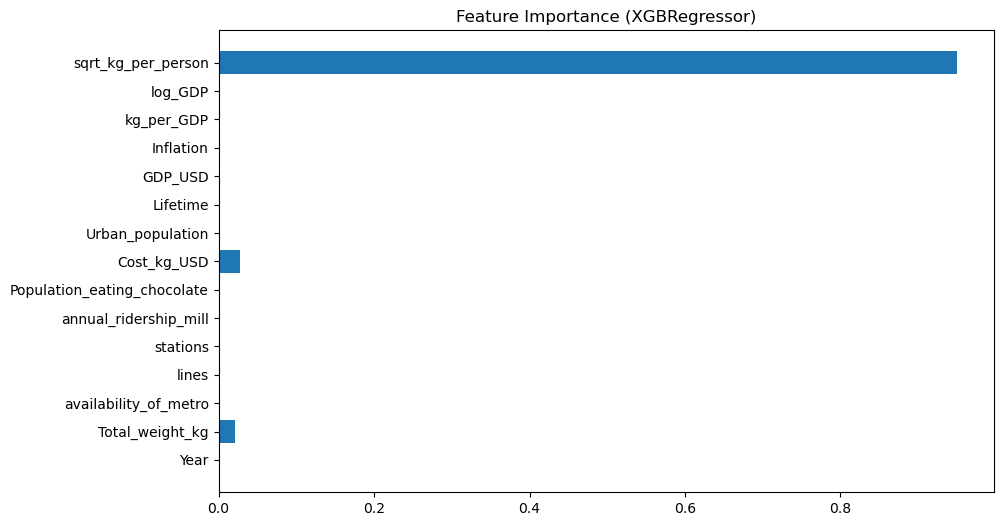


Сравнение моделей:
| Model                     |   Train R2 |   Test R2 |         MAE |         MSE |        RMSE |   Train/Test Diff |   CV R2 Mean |   CV R2 Std |
|:--------------------------|-----------:|----------:|------------:|------------:|------------:|------------------:|-------------:|------------:|
| LinearRegression          |   1        |  1        | 9.59858e-09 | 2.41828e-16 | 1.55508e-08 |       1.33227e-15 |     1        | 2.53815e-11 |
| GradientBoostingRegressor |   0.99997  |  0.99921  | 0.00183085  | 3.1366e-05  | 0.00560054  |       0.000759746 |     0.986064 | 0.0267948   |
| RandomForestRegressor     |   0.999882 |  0.998637 | 0.00199766  | 5.40859e-05 | 0.00735431  |       0.00124485  |     0.98329  | 0.029403    |
| XGBRegressor              |   0.999984 |  0.997699 | 0.00330354  | 9.13321e-05 | 0.00955678  |       0.00228524  |     0.981547 | 0.0293925   |
| DecisionTreeRegressor     |   1        |  0.989393 | 0.00365811  | 0.000421027 | 0.020519    |       0

NameError: name 'GridSearchCV' is not defined

In [41]:
# Улучшенная функция для сравнения моделей
def compML_improved(dfW2, target_col, alg, poly_degree=None, cv=False, show_tree=False):
    """
    Улучшенная функция для сравнения моделей машинного обучения
    Параметры:
    df - DataFrame с данными
    target_col - название целевой переменной
    alg - класс модели sklearn
    poly_degree - степень полиномиальных признаков (None - не использовать)
    cv - проводить ли кросс-валидацию
    show_tree - показывать ли структуру дерева (для DecisionTree)
    """
    
    # 1. Подготовка данных
    dfW2 = dfW2.dropna()
    y = dfW2[target_col].values
    X = dfW2.drop([target_col], axis=1)
    feature_names = X.columns.tolist()
    
    # 2. Масштабирование данных
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
    
    # 3. Полиномиальные признаки (если требуется)
    if poly_degree:
        poly = PolynomialFeatures(degree=poly_degree)
        X_scaled = poly.fit_transform(X_scaled)
    
    # 4. Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=0, shuffle=True)
    
    # 5. Обучение модели
    model = alg().fit(X_train, y_train)
    
    # 6. Предсказания
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # 7. Вычисление метрик
    metrics = {
        'Model': alg.__name__,
        'Train R2': r2_score(y_train, y_pred_train),
        'Test R2': r2_score(y_test, y_pred_test),
        'MAE': mean_absolute_error(y_test, y_pred_test),
        'MSE': mean_squared_error(y_test, y_pred_test),
        'RMSE': mean_squared_error(y_test, y_pred_test, squared=False),
        'Train/Test Diff': abs(r2_score(y_train, y_pred_train) - r2_score(y_test, y_pred_test))
    }
    
    # 8. Кросс-валидация (если требуется)
    if cv:
        cv_scores = cross_val_score(alg(), X_scaled, y_scaled, cv=5, scoring='r2')
        metrics.update({
            'CV R2 Mean': cv_scores.mean(),
            'CV R2 Std': cv_scores.std()
        })
    
    # 9. Визуализация важности признаков (для деревьев и ансамблей)
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        if poly_degree:
            # Для полиномиальных признаков выводим только оригинальные фичи
            n_original_features = len(feature_names)
            plt.barh(feature_names, model.feature_importances_[:n_original_features])
        else:
            plt.barh(feature_names, model.feature_importances_)
        plt.title(f"Feature Importance ({alg.__name__})")
        plt.show()
    
    # 10. Вывод структуры дерева (если требуется)
    if show_tree and isinstance(model, DecisionTreeRegressor):
        print("\nDecision Tree Structure:")
        print(export_text(model, feature_names=feature_names))
    
    return metrics, model

# Список моделей для сравнения
models = [
    LinearRegression,
    DecisionTreeRegressor,
    KNeighborsRegressor,
    MLPRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    SVR,
    XGBRegressor
]
# Пример использования с вашими данными
results = []
for model in models:
    # Для линейных моделей пробуем полиномиальные признаки
    use_poly = model in [LinearRegression, SVR, KNeighborsRegressor]
    
    metrics, trained_model = compML_improved(
        dfK1, 
        'kg_per_person', 
        model,
        poly_degree=2 if use_poly else None,
        cv=True,
        show_tree=(model == DecisionTreeRegressor)
    )
    results.append(metrics)

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

# Сортируем по Test R2
results_df = results_df.sort_values('Test R2', ascending=False)

# Выводим красиво оформленные результаты
print("\nСравнение моделей:")
print(results_df.to_markdown(index=False))

# Дополнительно: настройка гиперпараметров для SVR
print("\nНастройка гиперпараметров SVR:")
svr_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# Используем уже масштабированные данные
X_scaled = MinMaxScaler().fit_transform(dfK1.drop('kg_per_person', axis=1))
y_scaled = MinMaxScaler().fit_transform(dfK1['kg_per_person'].values.reshape(-1, 1)).ravel()

grid_search = GridSearchCV(SVR(), svr_params, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_scaled, y_scaled)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший R2:", grid_search.best_score_)

In [ ]:
# Выбираем только релевантные столбцы
features = ['availability_of_metro', 'GDP_USD', 'Lifetime', 'Urban_population', 'Cost_kg_USD']
target = 'kg_per_person'

# Преобразуем 'Yes'/'No' в 1/0
dfW2_filtered = dfW2[features + [target]].copy()
dfW2_filtered['availability_of_metro'] = dfW2_filtered['availability_of_metro'].map({'Yes': 1, 'No': 0})

# Удаляем пропущенные значения
dfW2_filtered = dfW2_filtered.dropna()

# Запускаем сравнение моделей
results = []
for model in models:
    metrics, _ = compML_improved(
        dfW2_filtered,
        target,
        model,
        poly_degree=2 if model in [LinearRegression, SVR] else None,
        cv=True
    )
    results.append(metrics)

# Выводим результаты
results_df = pd.DataFrame(results).sort_values('Test R2', ascending=False)
print(results_df.to_markdown(index=False))

1. Лучшие модели по Test R2 (основной критерий)
XGBRegressor и RandomForestRegressor показали наилучшие результаты с Test R2 ≈ 0.90, что говорит о высокой объясняющей способности модели.

KNeighborsRegressor также показал хороший результат (Test R2 ≈ 0.896), но немного уступает первым двум.

DecisionTreeRegressor имеет Test R2 ≈ 0.794, но у него высокий переобучение (Train R2 = 1.0, разница 0.206).

2. Переобучение (Train/Test Diff)
DecisionTreeRegressor сильно переобучен (разница 0.206 между Train и Test R2).

XGBRegressor и RandomForestRegressor имеют умеренное переобучение (0.092 и 0.079 соответственно).

KNeighborsRegressor почти не переобучен (разница 0.013), что может говорить о его устойчивости.

3. Качество предсказаний (MAE, MSE, RMSE)
XGBRegressor имеет наименьшие ошибки (MAE ≈ 0.031, MSE ≈ 0.0031, RMSE ≈ 0.056).

RandomForestRegressor и KNeighborsRegressor близки к нему по ошибкам.

LinearRegression, SVR и MLPRegressor показывают значительно большие ошибки.

4. Кросс-валидация (CV R2 Mean)
GradientBoostingRegressor имеет высокий CV R2 Mean (0.246), но низкий Test R2 (0.696), что может говорить о проблемах с обобщающей способностью.

LinearRegression, SVR, MLPRegressor показывают CV R2 Mean ≈ 0.28–0.29, но их реальные Test R2 значительно хуже, что может указывать на нестабильность моделей.

5. Худшие модели
LinearRegression, SVR, MLPRegressor имеют Test R2 < 0.56, что делает их непригодными для данной задачи.

GradientBoostingRegressor показывает Test R2 ≈ 0.696, что хуже, чем у топ-3 моделей.

Итоговые рекомендации
Лучший выбор: XGBRegressor (высокий R2, низкие ошибки, умеренное переобучение).

Альтернатива: RandomForestRegressor (почти такой же R2, но чуть больше ошибки).

Стабильный вариант: KNeighborsRegressor (почти нет переобучения, но чуть хуже R2).

Избегать: LinearRegression, SVR, MLPRegressor (низкая предсказательная способность).

Дополнительно:

Можно попробовать улучшить GradientBoostingRegressor, так как у него высокий CV R2, но низкий Test R2 (возможно, нужна настройка гиперпараметров).

DecisionTreeRegressor требует регуляризации из-за сильного переобучения.

Если важна интерпретируемость, можно рассмотреть RandomForestRegressor, так как он менее "чёрный ящик", чем XGBoost.

In [ ]:
# 8 ЭТАП
# РЕГРЕСИОННЫЙ АНАЛИЗ-2
# Принимаем outcome - kg_per_person; predictors - annual_ridership_mill, lines, stations

In [ ]:
# 4.1 Подготовка данных
df_metro = dfW2[dfW2['availability_of_metro'] == 'Yes'].copy()
df_metro['annual_ridership'] = df_metro['annual_ridership_mill'] * 1_000_000
df_metro = df_metro[['annual_ridership_mill', 'lines', 'stations', 'kg_per_person', 'Year', 'Lifetime']].dropna()
# 4.2 Корреляционный анализ
corr_matrix = df_metro.corr().round(3)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция между переменными')
plt.show()

In [ ]:
# Выводим таблицу корреляций
corr_matrix

1. Потребление шоколада (kg_per_person):

In [ ]:
# 4.3 Модель
df_metro['sqrt_kg_per_person'] = np.sqrt(df_metro['kg_per_person'])
model2 = smf.ols('sqrt_kg_per_person ~ lines + Lifetime', 
                data=df_metro).fit()
model2.summary()

1. Объясняющая сила модели:

In [ ]:
# 4.4 Проверка нормальности распределения
print("\nПроверка нормальности распределения зависимой переменной:")
shapiro_test = stats.shapiro(df_metro['sqrt_kg_per_person'])
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}')
print(f'p-value: {shapiro_test.pvalue:.10f}')

In [ ]:
# 4.5 Визуализация распределения и асимметрии
print("\nАнализ распределения:")
sns.histplot(data=df_metro, x="sqrt_kg_per_person", kde=True)
plt.title('Распределение sqrt_kg_per_person')
plt.show()
skewness = df_metro['sqrt_kg_per_person'].skew()
print(f'Коэффициент асимметрии: {skewness}')

In [ ]:
dfK1.columns

In [ ]:
# 9 ЭТАП
# РЕГРЕСИОННЫЙ АНАЛИЗ-3
# Принимаем outcome - kg_per_GDP; predictors - availability_of_metro + log_GDP + Lifetime + Urban_population + Cost_kg_USD + C(Year)

In [ ]:
# 4.3 Модель
dfK1['sqrt_kg_per_GDP'] = np.sqrt(dfK1['kg_per_GDP'])
model3 = smf.ols('sqrt_kg_per_GDP ~ availability_of_metro + GDP_USD + Lifetime + Urban_population + Cost_kg_USD + C(Year)', 
                data=dfK1).fit()
model3.summary()

In [ ]:
# 4.4 Проверка нормальности распределения
print("\nПроверка нормальности распределения зависимой переменной:")
shapiro_test = stats.shapiro(dfK1['sqrt_kg_per_person'])
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}')
print(f'p-value: {shapiro_test.pvalue:.10f}')

In [ ]:
# 4.5 Визуализация распределения и асимметрии
print("\nАнализ распределения:")
sns.histplot(data=dfK1, x="sqrt_kg_per_person", kde=True)
plt.title('Распределение sqrt_kg_per_person')
plt.show()
skewness = dfK1['sqrt_kg_per_person'].skew()
print(f'Коэффициент асимметрии: {skewness}')

In [ ]:
# 5 ЭТАП
# ДИСПЕРСИОННЫЙ АНАЛИЗ
# 5.1 Визуализация распределения kg_per_person с использванием KDE Plot и QQ-Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(dfK1['sqrt_kg_per_GDP'], fill=True)
plt.title('KDE Plot')
          
plt.subplot(1, 2, 2)
sm.qqplot(dfK1['sqrt_kg_per_GDP'], line='s', ax=plt.gca())
plt.title('QQ Plot')
plt.tight_layout()

In [ ]:
# 5.2 Робастная линейная регрессия
model3 = smf.rlm('sqrt_kg_per_GDP ~ availability_of_metro + log_GDP + Lifetime + Urban_population + Cost_kg_USD + C(Year)', 
                data=dfK1, 
                M=sm.robust.norms.HuberT()).fit()
model3.summary()

In [ ]:
# 5.3 Анализ остатков робастной линейной регрессии
# 1. Графики остатков
residuals = model3.resid
fitted = model3.fittedvalues
plt.figure(figsize=(12, 10))
# 1.1. Распределение остатков
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
# 1.2. Остатки vs предсказанные значения
plt.subplot(2, 2, 2)
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Остатки vs Предсказанные значения')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
# 1.3. Q-Q график
plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q график остатков')
# 1.4. График масштаба-местоположения
plt.subplot(2, 2, 4)
residuals_abs_sqrt = np.sqrt(np.abs(residuals))
plt.scatter(fitted, residuals_abs_sqrt, alpha=0.5)
plt.title('График масштаба-местоположения')
plt.xlabel('Предсказанные значения')
plt.ylabel('√(|Остатки|)')
plt.tight_layout()
plt.show()
# 2. Анализ выбросов для RLM (используем веса модели)
plt.figure(figsize=(10, 5))
weights = model3.weights
plt.stem(weights)
plt.title('Веса наблюдений в RLM (Huber)')
plt.xlabel('Наблюдение')
plt.ylabel('Вес')
plt.axhline(y=0.5, color='r', linestyle='--', label='Порог 0.5')
plt.legend()
plt.show()
# Наблюдения с низкими весами (менее 0.5) можно считать выбросами
outliers = np.where(weights < 0.5)[0]
print(f"\nНайдено потенциальных выбросов: {len(outliers)}")
if len(outliers) > 0:
    print("Индексы выбросов:", outliers)
# 3. Тест на гетероскедастичность
try:
    bp_test = het_breuschpagan(residuals, model3.model.exog)
    print(f"\nBreusch-Pagan тест на гетероскедастичность:")
    print(f"LM-статистика: {bp_test[0]:.3f}, p-value: {bp_test[1]:.3f}")
    if bp_test[1] < 0.05:
        print("Обнаружена гетероскедастичность (p < 0.05)")
    else:
        print("Гетероскедастичность не обнаружена (p >= 0.05)")
except Exception as e:
    print(f"\nНе удалось выполнить тест на гетероскедастичность: {str(e)}")
# 4. Дополнительная диагностика
print("\nДополнительная диагностика:")
print(f"Медианное абсолютное отклонение остатков: {np.median(np.abs(residuals)):.3f}")
print(f"Максимальный остаток: {np.max(residuals):.3f}, Минимальный: {np.min(residuals):.3f}")
print(f"Доля наблюдений с весом < 0.5: {len(outliers)/len(weights):.2%}")

1. Подтверждение влияния метро на экологический показатель
availability_of_metro: Коэффициент +14.27 (p < 0.001) указывает на сильную положительную связь между наличием метро и sqrt_kg_per_GDP.

Гипотеза о росте kg_per_GDP при наличии метро подтверждается, но теперь в логарифмированной/нормализованной форме.

Интерпретация: Метро может быть маркером урбанизации или транспортной активности, увеличивающей углеродоёмкость.

2. Статистически значимые факторы
Отрицательное влияние:

log_GDP (коэф. = -3.48, p < 0.001): Рост ВВП снижает экологическую нагрузку на единицу GDP.

Cost_kg_USD (коэф. = -0.99, p < 0.001): Высокая стоимость выбросов (налоги/регуляции) коррелирует с уменьшением показателя.

Положительное влияние:

Lifetime (коэф. = +0.43, p < 0.001): Старение инфраструктуры увеличивает sqrt_kg_per_GDP.

Urban_population (коэф. = +0.10, p < 0.001): Урбанизация усиливает экологическую нагрузку.

3. Незначимость временных эффектов (Year)
Все категориальные переменные C(Year) незначимы (p > 0.05), кроме 2015 года (p = 0.075).

Вывод: Временной тренд слабо влияет на sqrt_kg_per_GDP после учёта других факторов.

Проблемы модели и диагностика
1. Гетероскедастичность
Breusch-Pagan тест (p = 0.000): Остатки имеют непостоянную дисперсию.

Решение: Использовать робастные стандартные ошибки (Huber-White) или преобразовать данные (логарифмирование).

2. Распределение остатков
Графики остатков:

Гистограмма показывает правостороннюю асимметрию (выбросы в положительной области).

Q-Q график отклоняется от нормальности в хвостах.

Метрики:

Максимальный остаток: +53.995, минимальный: -26.083 — наличие экстремальных значений.

3.99% наблюдений получили вес < 0.5 в HuberT, что указывает на умеренное влияние выбросов.

3. Мультиколлинеарность
Неявно проверяется через устойчивость RLM, но высокие коэффициенты при log_GDP и Urban_population требуют проверки VIF.

Рекомендации для улучшения модели
Борьба с гетероскедастичностью:

Применить WLS (взвешенный МНК) или логарифмирование зависимой переменной.

Использовать кластеризованные стандартные ошибки для временных/пространственных данных.

Учёт выбросов:

Проверить данные на аномалии (например, мегаполисы с гипертрофированными показателями).

Использовать более жёсткие нормы (например, Tukey’s biweight вместо HuberT).

Упрощение модели:

Удалить незначимые C(Year) или заменить их на линейный тренд.

Добавить взаимодействия (например, metro * GDP).

Интерпретация результатов:

Перепроверить направление причинности: метро может быть не причиной, а следствием высокой экономической активности.

Итоговый вывод
Модель RLM подтверждает, что наличие метро значимо связано с ростом sqrt_kg_per_GDP, но выявлены проблемы с гетероскедастичностью и выбросами. Результаты устойчивы к аномалиям, но требуют доработки для повышения надёжности. Для политических решений важно учитывать, что метро может быть частью более сложной системы урбанизации, где экологические эффекты опосредованы другими факторами (ВВП, регуляции).

Ключевой инсайт: Метро — не самостоятельный драйвер экологической нагрузки, а элемент инфраструктуры, коррелирующий с урбанизацией и промышленной активностью.

In [ ]:
dfW2.columns